# N02A - Fully Supervised Training with Low-Level Features

In this notebook, we go through the fully supervised training of the LHCO AD datasets with low-level (+ high-level) features in the particle cloud representation.

## Step 1: Data Loading

- For the moment, data are loaded in memory instead of lazily.

In [1]:
import os
import awkward as ak
import tensorflow as tf

input_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq"
filenames = {
    "signal"           : os.path.join(input_dir, "col_based", "SR_point_cloud_W_qq_500_100_official.parquet"),
    "background"       : os.path.join(input_dir, "col_based", "SR_point_cloud_QCD_qq.parquet"),
    "extra_background" : os.path.join(input_dir, "col_based", "SR_point_cloud_extra_QCD_qq.parquet"),
}

2023-11-22 13:16:52.712046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check software version

In [2]:
print(f'awkward version     : {ak.__version__}')
print(f'tensorflow version  : {tf.__version__}')

awkward version     : 2.4.6
tensorflow version  : 2.12.1


### Check GPU device

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Wed Nov 22 13:21:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   43C    P0    43W / 250W |  26200MiB / 40960MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Point Cloud data

In [5]:
from aliad.data import PointCloudDataset

In [6]:
feature_dict = {
        "part_coords"   : ["part_delta_eta", "part_delta_phi"],
        "part_features" : ["part_pt", "part_delta_eta", "part_delta_phi", "part_delta_R"],
        "jet_features"  : ["jet_pt", "jet_eta", "jet_phi", "jet_m", "N", "tau12", "tau23"]
}
class_labels = {
    0: ["background", "extra_background"],
    1: ["signal"],
}
## change your dataset sizes here
#sample_sizes = {
#    "background": 1000,
#    "signal"    :  100
#}
sample_sizes = None
dataset = PointCloudDataset(class_labels=class_labels, feature_dict=feature_dict,
                            sample_sizes=sample_sizes, num_jets=2, pad_size=300, shuffle=False)

In [7]:
dataset.load(filenames)

[INFO] Loading dataset from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq/col_based/SR_point_cloud_QCD_qq.parquet"
[INFO] Preparing data for the sample "background" (class = 0)
[INFO] Size of sample data: 121351
[INFO] Working on feature type "part_coords"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Jet index: 2
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Working on feature type "part_features"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_pt"
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Loading data for the feature "part_delta_R"
[INFO] Jet index: 2
[INFO] Loading data for the feature "part_pt"
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Loading dat

In [8]:
# particle coordinates for the first event
print("Particle coordinates for the first jet for the first event\n")
print(f"Shape : {dataset.X['part_coords'][0][0].shape} = (nparticles, ncoordinates) ")
print(f"Data  : {dataset.X['part_coords'][0][0]}")

Particle coordinates for the first jet for the first event

Shape : (300, 2) = (nparticles, ncoordinates) 
Data  : [[-0.19092877  0.91749602]
 [ 0.56061639 -0.57879791]
 [ 0.18289359 -0.5255839 ]
 [ 0.22993635 -0.50694856]
 [ 0.23695891 -0.4938927 ]
 [ 0.23610357 -0.48112628]
 [ 0.18422658 -0.49149552]
 [ 0.20430046 -0.4725487 ]
 [ 0.26115908 -0.43871776]
 [ 0.17761825 -0.46610216]
 [ 0.26369242 -0.42128209]
 [ 0.21442084 -0.38887886]
 [ 0.28163147 -0.33917639]
 [ 0.12959278 -0.41768805]
 [-0.0032293  -0.43070111]
 [-0.43152319  0.22914461]
 [ 0.16755397 -0.2976617 ]
 [ 0.14752272 -0.2901688 ]
 [ 0.05374113 -0.29615322]
 [-0.15246804 -0.13844648]
 [-0.05601607 -0.11145488]
 [-0.11797993  0.09873679]
 [ 0.01707571 -0.06304995]
 [ 0.02698519  0.01319962]
 [ 0.00592681  0.00837871]
 [ 0.01154526  0.03473192]
 [-0.015988    0.03542962]
 [-0.01575802  0.04321059]
 [-0.01446037  0.04383355]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.    

In [9]:
# particle coordinates for the first event
print("Particle features for the second jet for the first event\n")
print(f"Shape : {dataset.X['part_features'][0][1].shape} = (nparticles, nfeatures) ")
print(f"Data  : {dataset.X['part_features'][0][1]}")

Particle features for the second jet for the first event

Shape : (300, 4) = (nparticles, nfeatures) 
Data  : [[ 5.76006949e-04  1.71661966e-01  8.99998133e-01  9.16222937e-01]
 [ 2.71377951e-04  6.29497998e-01 -6.28864407e-01  8.89796702e-01]
 [ 1.43928969e-03 -5.28438759e-02 -2.33094096e-01  2.39009064e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [10]:
# jet coordinates for the first event
print("Jet features for the first jet for the first event\n")
print(f"Shape : {dataset.X['jet_features'][0][1].shape} = (nfeatures) ")
print(f"Data  : {dataset.X['jet_features'][0][1]}")

Jet features for the first jet for the first event

Shape : (7,) = (nfeatures) 
Data  : [ 1.58957248  0.31623674  2.74671447  0.03889603 14.          0.58331666
  0.880918  ]


In [11]:
## event weights (normalized such that sum of weight of each class is 1)
#print("Event weights\n")
#print(f"Shape : {dataset.weight.shape}")
#print(f"Data  : {dataset.weight}")

### Create train-validation-test splits

In [12]:
from aliad.data import split_dataset
from aliad.utils.system_utils import print_memory_usage

In [13]:
dataset_split = split_dataset(dataset.X, dataset.y, val_size=0.25, test_size=0.25, shuffle=True, seed=2023)
# free up memory
dataset.clear()

In [14]:
print_memory_usage(dataset_split)

X_train:
    part_coords: 3.62 GB
    part_features: 7.24 GB
    jet_features: 43.23 MB
    part_masks: 231.60 MB
y_train: 3.09 MB
X_val:
    part_coords: 1.81 GB
    part_features: 3.62 GB
    jet_features: 21.62 MB
    part_masks: 115.80 MB
y_val: 1.54 MB
X_test:
    part_coords: 1.81 GB
    part_features: 3.62 GB
    jet_features: 21.62 MB
    part_masks: 115.80 MB
y_test: 1.54 MB
Total Memory Usage: 22.26 GB


23896528560

### Prepare dataset in tensorflow.data.Dataset format

In [15]:
from aliad.interface.tensorflow.dataset import prepare_dataset
batch_size = 32
train_ds = prepare_dataset(dataset_split['X_train']['part_coords'],
                           dataset_split['X_train']['part_features'],
                           dataset_split['X_train']['part_masks'],
                           dataset_split['X_train']['jet_features'],
                           y=dataset_split['y_train'],
                           batch_size=batch_size,
                           shuffle=True,
                           # can't set too high buffer size due to memory constraint
                           buffer_size=1024,
                           seed=2023)
val_ds = prepare_dataset(dataset_split['X_val']['part_coords'],
                         dataset_split['X_val']['part_features'],
                         dataset_split['X_val']['part_masks'],
                         dataset_split['X_val']['jet_features'],
                         y=dataset_split['y_val'],
                         batch_size=batch_size,
                         shuffle=False)
test_ds = prepare_dataset(dataset_split['X_test']['part_coords'],
                          dataset_split['X_test']['part_features'],
                          dataset_split['X_test']['part_masks'],
                          dataset_split['X_test']['jet_features'],
                          y=dataset_split['y_test'],
                          batch_size=batch_size,
                          shuffle=False)

2023-11-22 13:25:27.131254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4041 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-11-22 13:25:29.280050: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7771219200 exceeds 10% of free system memory.


# Step 2: Create Modified ParticleNet Model 

In [ ]:
from typing import Optional, Union, List, Tuple

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (BatchNormalization, Activation,
                                     Conv3D, Dense, Dropout)

from quickstats import semistaticmethod, AbstractObject
from quickstats.utils.common_utils import combine_dict

from aliad.interface.tensorflow.layers import EdgeConv

class ModifiedParticleNet(AbstractObject):

    DEFAULT_CONFIG = {
        "num_points"  : 300,
        "num_jets"    : 2,
        "num_class"   : 1,
        "K"           : 16,
        "conv_params" : [(64, 64, 64),
                         (128, 128, 128),
                         (256, 256, 256)],
        "fc_params"   : [(256, 0.1)],
        "pool_method" : "average",
        "batchnorm"   : True,
        "activation"  : "relu"
    }
    
    def __init__(self, config:Optional[dict]=None,
                 verbosity:str="INFO"):
        super().__init__(verbosity=verbosity)
        self.config = combine_dict(self.DEFAULT_CONFIG, config)
    
    def get_model(self, points, features=None, masks=None,
                  jet_features=None, name='ParticleNet'):
        # points       : (nevent, njet, nparticle, ncoords)
        # features     : (nevent, njet, nparticle, nfeatures)
        # masks        : (nevent, njet, nparticle, 1)
        # jet_features : (nevent, njet, njetfeatures)
    
        with tf.name_scope(name):
            if features is None:
                features = points
    
            if masks is not None:
                coord_shift = tf.multiply(99., tf.cast(tf.expand_dims(masks, axis=-1), dtype='float32'))
            else:
                coord_shift = None
            fts = tf.expand_dims(features, axis=-2)
            fts = BatchNormalization(name=f"{name}_fts_bn")(fts)
            fts = tf.squeeze(fts, axis=-2)
            for layer_idx, layer_channels in enumerate(self.config['conv_params']):
                pts = points if layer_idx == 0 else fts
                if masks is not None:
                    pts = tf.add(coord_shift, pts)
                fts = EdgeConv(pts, fts, channels=layer_channels,
                               K=self.config['K'], 
                               batchnorm=self.config['batchnorm'],
                               activation=self.config['activation'],
                               pooling=self.config['pool_method'],
                               name=f'{name}_EdgeConv{layer_idx}')
    
            if masks is not None:
                fts_mask = tf.cast(tf.math.logical_not(tf.expand_dims(masks, axis=-1)), dtype='float32')
                fts = tf.multiply(fts, fts_mask)

            # shape = (nevent, njet, nchannel)
            pool = tf.reduce_mean(fts, axis=-2)
            if jet_features is not None:
                pool = tf.concat([pool, jet_features], -1)
            pool_shape = tf.shape(pool)
            out = tf.reshape(pool, (-1, tf.reduce_prod(pool_shape[1:])))
    
            if self.config['fc_params'] is not None:
                x = out
                for layer_idx, layer_param in enumerate(self.config['fc_params']):
                    units, drop_rate = layer_param
                    x = Dense(units, activation='relu')(x)
                    if drop_rate is not None and drop_rate > 0:
                        x = Dropout(drop_rate)(x)
                out = Dense(self.config['num_class'], activation='sigmoid')(x)
                
            inputs = [points, features]
            if masks is not None:
                inputs.append(masks)
            if jet_features is not None:
                inputs.append(jet_features)
        model = Model(inputs=inputs, outputs=out, name=name)
        return model

In [ ]:
# for reproducibility
tf.random.set_seed(2023)
points        = Input(name='part_coords', shape=dataset_split['X_train']['part_coords'].shape[1:])
features      = Input(name='part_features', shape=dataset_split['X_train']['part_features'].shape[1:])
masks         = Input(name='part_masks', shape=dataset_split['X_train']['part_masks'].shape[1:], dtype='bool')
jet_features  = Input(name='jet_features', shape=dataset_split['X_train']['jet_features'].shape[1:])
model_builder = ModifiedParticleNet()
model = model_builder.get_model(points, features, masks=masks, jet_features=jet_features)

### Build tensorflow model

In [ ]:
steps_per_epoch = dataset_split['y_train'].shape[0] / batch_size
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 20,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/low_level_full_dataset_SR_v1',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': int(steps_per_epoch * 1)
        }
    }
}

In [ ]:
optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
model.compile(loss=config['loss'],
              optimizer=optimizer,
              metrics=config['metrics'])

### Prepare callbacks

In [ ]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, BatchMetricsCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
batch_metrics = BatchMetricsCallback()
callbacks = [lr_scheduler, early_stopping, checkpoint, batch_metrics]

In [ ]:
# free up memory
dataset_split['X_train'] = None
dataset_split['X_val'] = None
dataset_split['y_train'] = None
dataset_split['y_val'] = None

### Show model summary

In [23]:
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 part_masks (InputLayer)        [(None, 2, 300)]     0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 2, 300, 1)    0           ['part_masks[0][0]']             
                                                                                                  
 tf.cast (TFOpLambda)           (None, 2, 300, 1)    0           ['tf.expand_dims[0][0]']         
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 2, 300, 1)    0           ['tf.cast[0][0]']                
                                                                                        

## Step 3: Train Model

In [22]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=config['epochs'],
          callbacks=callbacks)

2023-11-13 02:32:52.826863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [404751,2,300,4]
	 [[{{node Placeholder/_1}}]]


Epoch 1/20


2023-11-13 02:32:57.708407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-11-13 02:33:00.566595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12648/12648 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9767

2023-11-13 02:47:25.721264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [202375,2,7]
	 [[{{node Placeholder/_3}}]]


12648/12648 [==============================] - 1112s 87ms/step - loss: 0.0702 - accuracy: 0.9767 - val_loss: 0.1108 - val_accuracy: 0.9608
Epoch 2/20
12648/12648 [==============================] - 1103s 87ms/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.0479 - val_accuracy: 0.9839
Epoch 3/20
12648/12648 [==============================] - 1102s 87ms/step - loss: 0.0495 - accuracy: 0.9839 - val_loss: 0.0450 - val_accuracy: 0.9856
Epoch 4/20
12648/12648 [==============================] - 1700s 134ms/step - loss: 0.0474 - accuracy: 0.9843 - val_loss: 0.0423 - val_accuracy: 0.9860
Epoch 5/20
12648/12648 [==============================] - 2055s 163ms/step - loss: 0.0458 - accuracy: 0.9849 - val_loss: 0.0516 - val_accuracy: 0.9827
Epoch 6/20
12648/12648 [==============================] - 2202s 174ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0460 - val_accuracy: 0.9846
Epoch 7/20
12648/12648 [==============================] - 1545s 122ms/step - loss: 0.0439 - accuracy: 0.9855

### Save model output

In [23]:
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model.save(filename)

In [24]:
# save metrics history from training and evaluation
import json
metrics_history = {
    "train": batch_metrics.batch_train_metrics,
    "val": batch_metrics.batch_val_metrics,
}
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
json.dump(metrics_history, open(filename, "w"))

## Model Testing

In [24]:
#filename = "/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/low_level_full_dataset_SR_v1/full_train_20_epoch.keras"
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model = tf.keras.models.load_model(filename)

In [29]:
predicted_proba = model.predict(test_ds)

2023-11-21 22:27:13.991511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [202376,2,7]
	 [[{{node Placeholder/_3}}]]


   2/6324 [..............................] - ETA: 5:45    

2023-11-21 22:27:50.374397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-11-21 22:27:50.392996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6324/6324 [==============================] - 1007s 153ms/step


In [30]:
import numpy as np
y_pred = np.round(predicted_proba.flatten())

In [31]:
y_true = np.array([y for (x, y) in test_ds]).flatten()

In [30]:
accuracy = np.mean(y_true == y_pred)
accuracy

0.9861984108159393

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
fpr, tpr, _ = roc_curve(y_true, predicted_proba.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9954770138480151

### Evaluate Error from Bootstrapping

In [32]:
def get_bootstrap_prediction(y_pred, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_predictions = []
    bootstrap_truths = []
    sample_size = y_pred.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        bootstrap_indices = np.random.choice(sample_size, sample_size, replace=True)
        bootstrap_y_pred = y_pred[bootstrap_indices]
        bootstrap_y_true = y_true[bootstrap_indices]
        bootstrap_predictions.append(bootstrap_y_pred)
        bootstrap_truths.append(bootstrap_y_true)
    bootstrap_predictions = np.array(bootstrap_predictions)
    bootstrap_truths = np.array(bootstrap_truths)
    return bootstrap_predictions, bootstrap_truths

In [33]:
num_bootstrap_samples = 100
bootstrap_predictions, bootstrap_truths = get_bootstrap_prediction(predicted_proba.flatten(),
                                                                   y_true,
                                                                   num_bootstrap_samples=num_bootstrap_samples,
                                                                   seed=2023)

In [34]:
bootstrap_y_pred = np.round(bootstrap_predictions)

In [35]:
bootstrap_accuracy = np.mean(bootstrap_y_pred == bootstrap_truths, axis=1)
bootstrap_fpr, bootstrap_tpr, bootstrap_auc = [], [], []
for i in range(num_bootstrap_samples):
    bs_fpr, bs_tpr, _ = roc_curve(bootstrap_truths[i], bootstrap_predictions[i])
    bs_roc_auc = auc(bs_fpr, bs_tpr)
    bootstrap_fpr.append(bs_fpr)
    bootstrap_tpr.append(bs_tpr)
    bootstrap_auc.append(bs_roc_auc)
bootstrap_auc = np.array(bootstrap_auc)

In [36]:
from scipy.interpolate import interp1d
def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+1e-3))
        sic_function = interp1d(tpr, tpr/((fpr+1e-3)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

In [37]:
tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                            bootstrap_fpr)

### Save test outputs

In [38]:
from quickstats.utils.common_utils import NpEncoder
import numpy as np
import json
results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'accuracy': accuracy,
    'auc': roc_auc,
    'tpr': tpr,
    'fpr': fpr,
    'bootstrap_predicted_proba': bootstrap_predictions,
    'bootstrap_y_true': bootstrap_truths,
    'bootstrap_y_pred': bootstrap_y_pred,
    'bootstrap_tpr': bootstrap_tpr,
    'bootstrap_fpr': bootstrap_fpr,
    'bootstrap_accuracy': bootstrap_accuracy,
    'bootstrap_auc': bootstrap_auc,
    'tpr_manual': tpr_manual,
    'roc_median': roc_median,
    'roc_std': roc_std
}
filename = os.path.join(config['checkpoint_dir'], "test_results.json")
json.dump(results, open(filename, "w"), cls=NpEncoder)

## Visualization

### Loss, Accuracy Curves

In [39]:
import json
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
metrics_history = json.load(open(filename))
num_epochs = 13
dfs = {}
for key, value in metrics_history.items():
    dfs[key] = pd.DataFrame(value)
    steps_per_epoch = dfs[key].shape[0] // num_epochs
    dfs[key]['epoch'] = (dfs[key].index + 1) / steps_per_epoch

In [44]:
from quickstats.plots import General1DPlot
label_map = {
    'train': 'Train',
    'val': 'Validation'
}
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.85),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.7, 0.75)
    }
}
plotter = General1DPlot(dfs, color_cycle='checker',
                        label_map=label_map, styles=styles,
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='Epoch', ylabel='Loss'>

<Figure size 640x480 with 0 Axes>

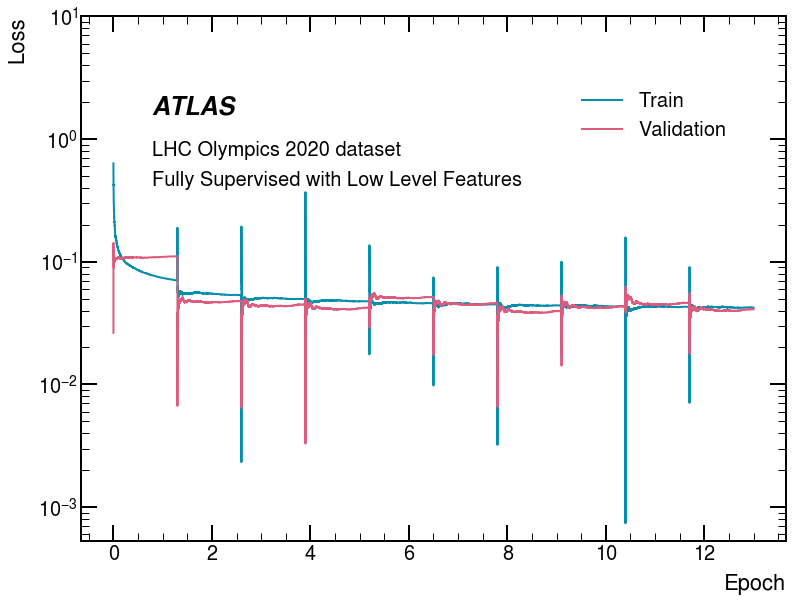

In [45]:
plotter.draw('epoch', 'loss', logy=True, xlabel='Epoch', ylabel='Loss', ymax=1e1)

<Axes: xlabel='Epoch', ylabel='Accuracy'>

<Figure size 640x480 with 0 Axes>

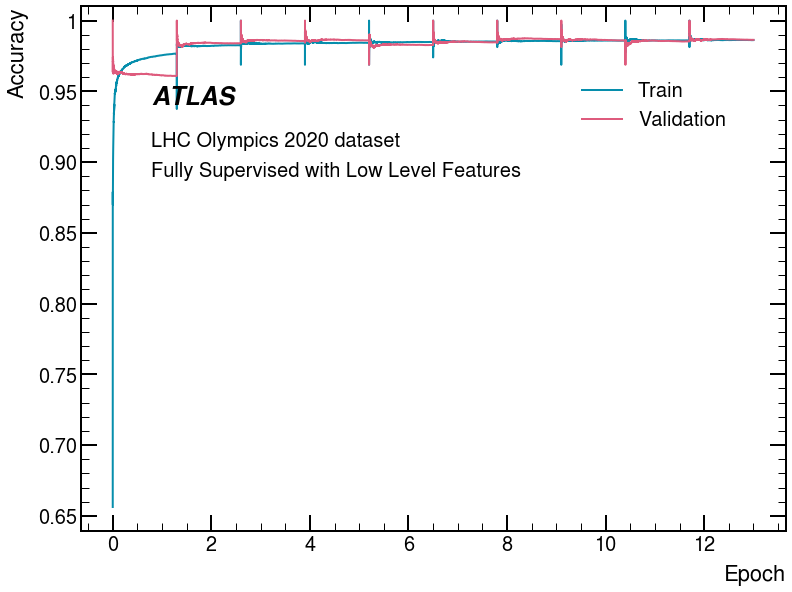

In [46]:
plotter.draw('epoch', 'accuracy', xlabel='Epoch', ylabel='Accuracy', ymax=1.01)

### model output (score) distribution

In [47]:
sig_mask = y_true == 1
bkg_mask = y_true == 0
dfs = {
    'Signal'     : pd.DataFrame({"score": predicted_proba.flatten()[sig_mask]}),
    'Background' : pd.DataFrame({"score": predicted_proba.flatten()[bkg_mask]})
}

In [48]:
from quickstats.plots import VariableDistributionPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.12, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.65, 0.8)
    }
}
plotter = VariableDistributionPlot(dfs, color_cycle='checker',
                                   styles=styles, analysis_label_options=analysis_label_options)

<Axes: xlabel='Predicted Prob.', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

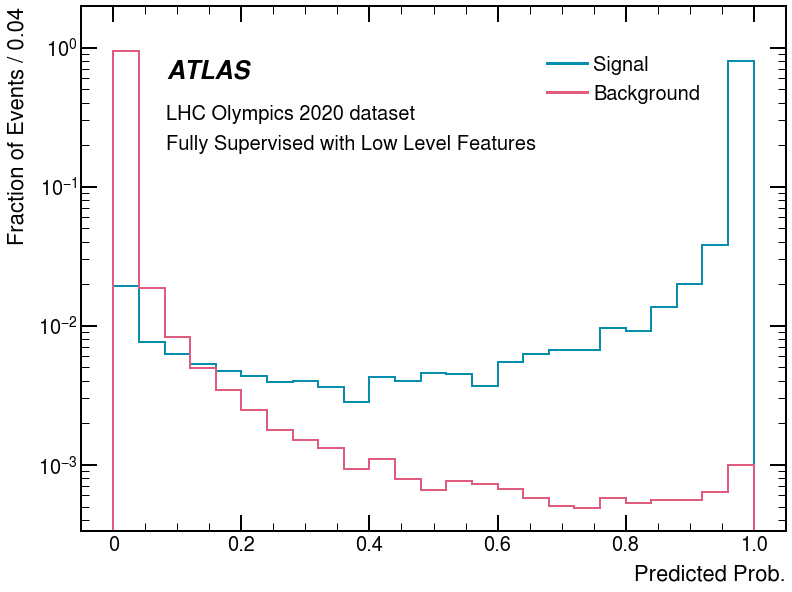

In [49]:
plotter.draw('score', xlabel='Predicted Prob.', bin_range=(0, 1), logy=True)

### AUC Curve

In [53]:
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.05, 0.8),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features//AUC = {roc_auc:.3f}'
}
df = pd.DataFrame({"fpr_inv": roc_median, "tpr": tpr_manual})
plotter = General1DPlot(df, color_cycle=['rust'],
                        analysis_label_options=analysis_label_options)

<Figure size 640x480 with 0 Axes>

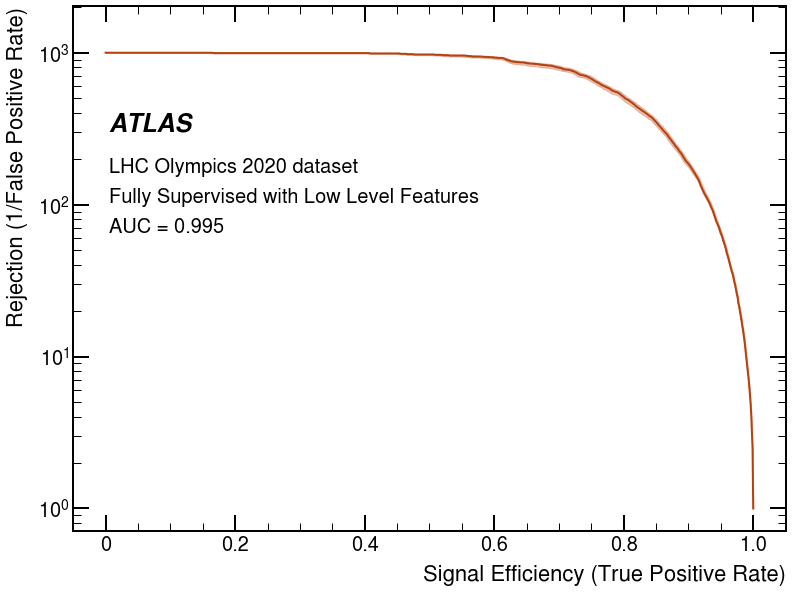

In [54]:
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)")
ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

### Event display

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from quickstats.plots import get_cmap
def display_event_image(x_features, x_masks, y, y_pred, indices=None,
                        ncol=4, dpi=72, figsize=(20, 8), alpha=0.5):
    if indices is not None:
        x_features = x_features[indices]
        x_masks = x_masks[indices]
        y, y_pred = y[indices], y_pred[indices]
    batchsize = x_features.shape[0]
    nrows = math.ceil(batchsize/ncol)
    for i in range(nrows):
        fig, axes = plt.subplots(nrows=2, ncols=ncol, dpi=dpi,
                                 facecolor='#FFFFFF', figsize=figsize)
        for j in range(ncol):
            idx = i * ncol + j
            if idx >= batchsize:
                break
            label, label_pred = y[idx], y_pred[idx]
            color = 'green' if (label == label_pred) else 'red'
            title = 'QCD Dijet' if label == 0 else r"$Z \rightarrow XY$"
            for jet_idx in [0, 1]:
                masks = ~x_masks[idx][jet_idx]
                x = x_features[idx][jet_idx][masks]
                pT  = x[:, 0] * 1000
                eta = x[:, 1]
                phi = x[:, 2]
                if ncol == 1:
                    ax = axes[jet_idx]
                else:
                    ax = axes[jet_idx][j]
                color = 'hdbs:maroonX11' if label == 1 else 'hdbs:starcommandblue'
                ax.scatter(eta, phi, pT, alpha=alpha, color=color)
                ax.scatter(eta, phi, pT, facecolors='none', color=color, linewidth=0.5)
                ax.xaxis.set_major_locator(ticker.NullLocator())
                ax.yaxis.set_major_locator(ticker.NullLocator())
                color='k'
                for spine in ax.spines.values():
                    spine.set_edgecolor(color)
                    spine.set_linewidth(1)
                if jet_idx == 0:
                    ax.set_title(title, fontsize=20, fontweight="bold")
        plt.subplots_adjust(wspace=None, hspace=0, top=0.90)

In [35]:
x_features = dataset_split['X_test']['part_features']
x_masks    = dataset_split['X_test']['part_masks']

In [36]:
import numpy as np
y_true = np.zeros(x_features.shape[0])
y_pred = np.zeros(x_features.shape[0])

In [37]:
y_true[41] = 1
y_pred[41] = 1

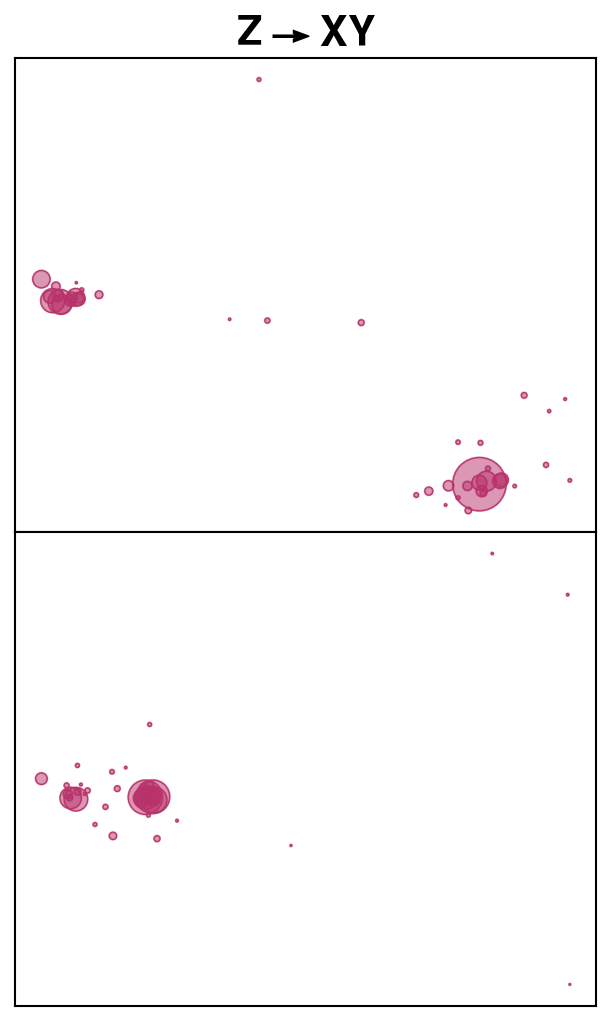

In [40]:
import matplotlib.pyplot as plt
# show 200 events, I make the range such that there exists at least one wrongly labelled event
# those framed in green are correctly labelled, and those in red are incorrectly labelled
display_event_image(x_features, x_masks, y_true, y_pred, [41], ncol=1, dpi=150, figsize=(5, 8))
plt.savefig("Z_XY.pdf", bbox_inches='tight')

In [ ]:
x_features = dataset_split['X_test']['part_features']
x_masks    = dataset_split['X_test']['part_masks']


In [42]:
import matplotlib.pyplot as plt

/tmp/ipykernel_262627/3012939467.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2, ncols=ncol, dpi=dpi,


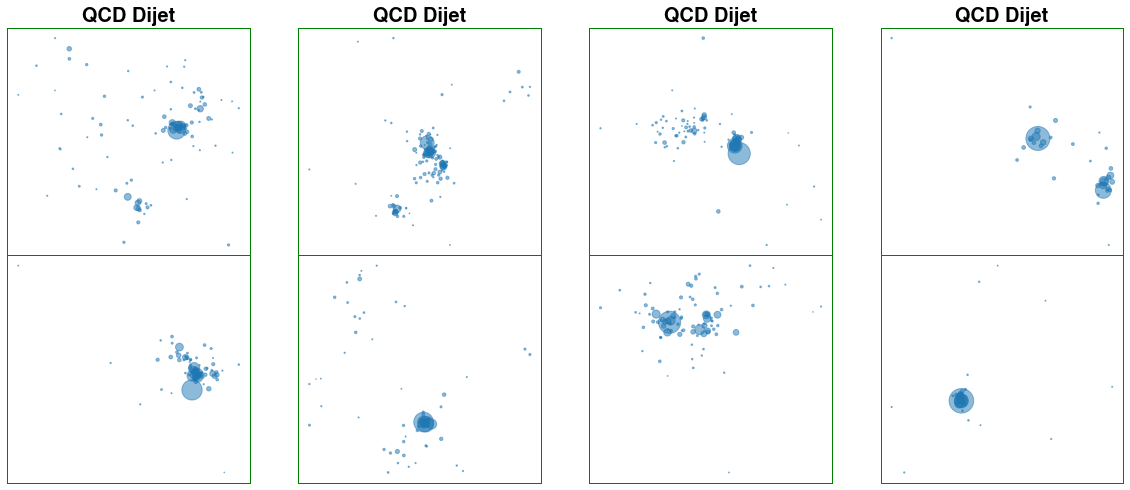

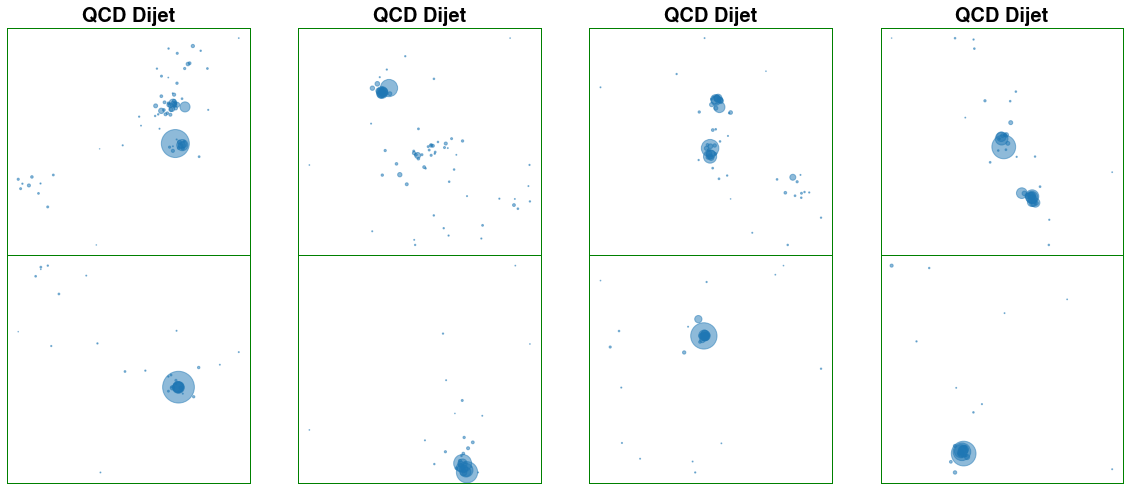

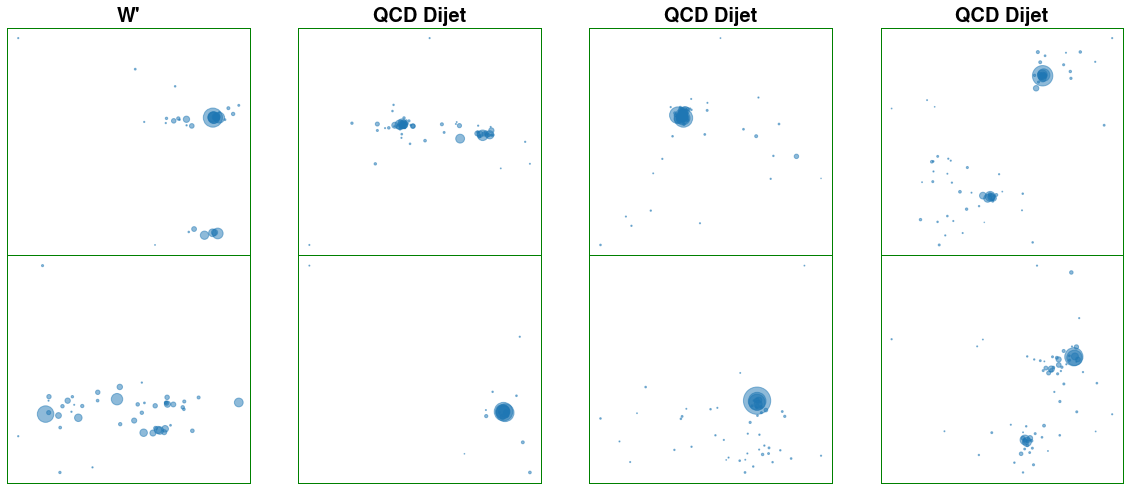

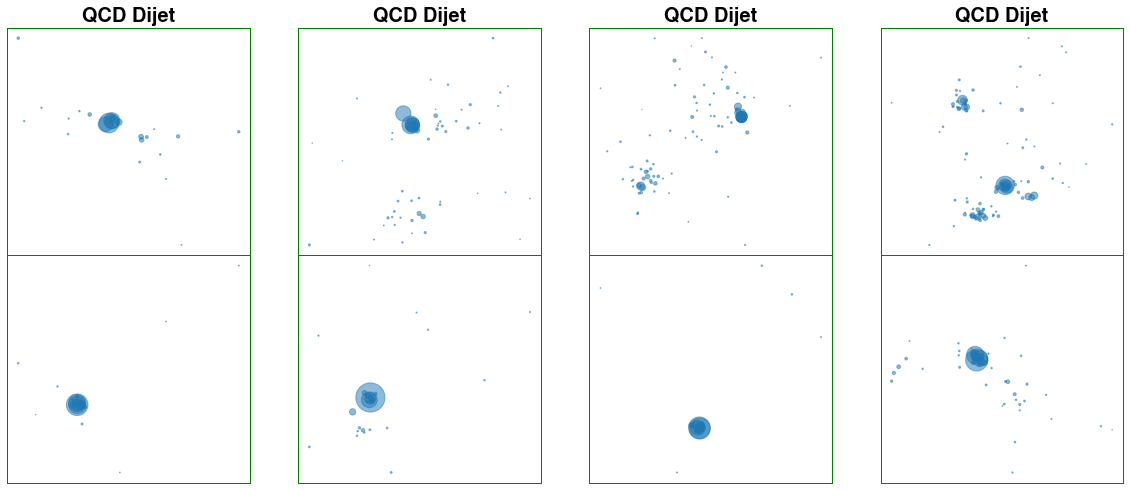

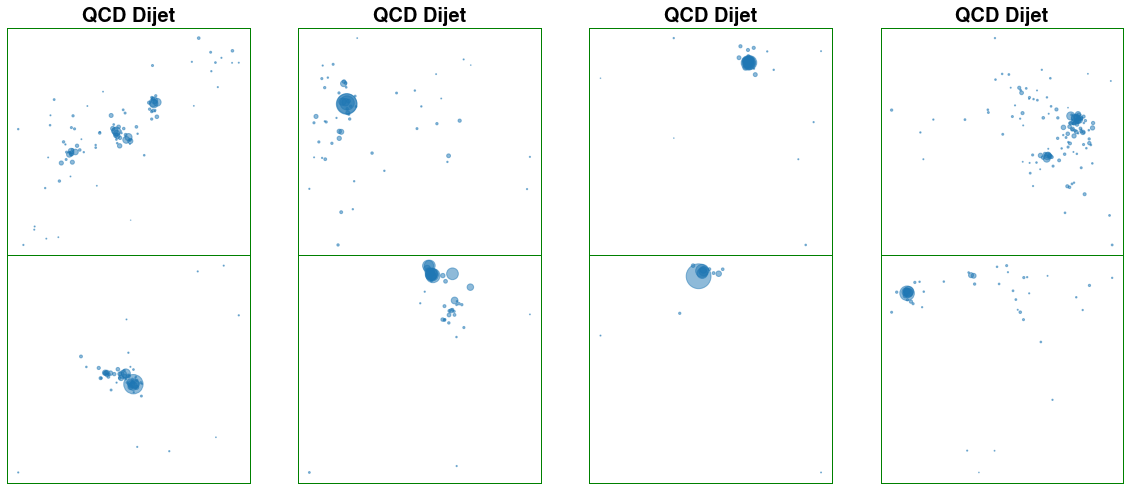

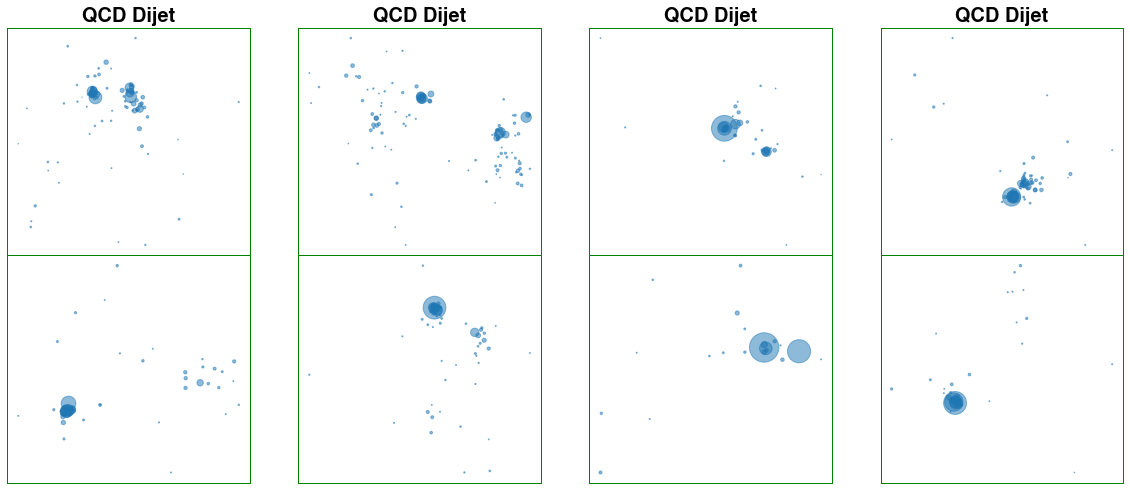

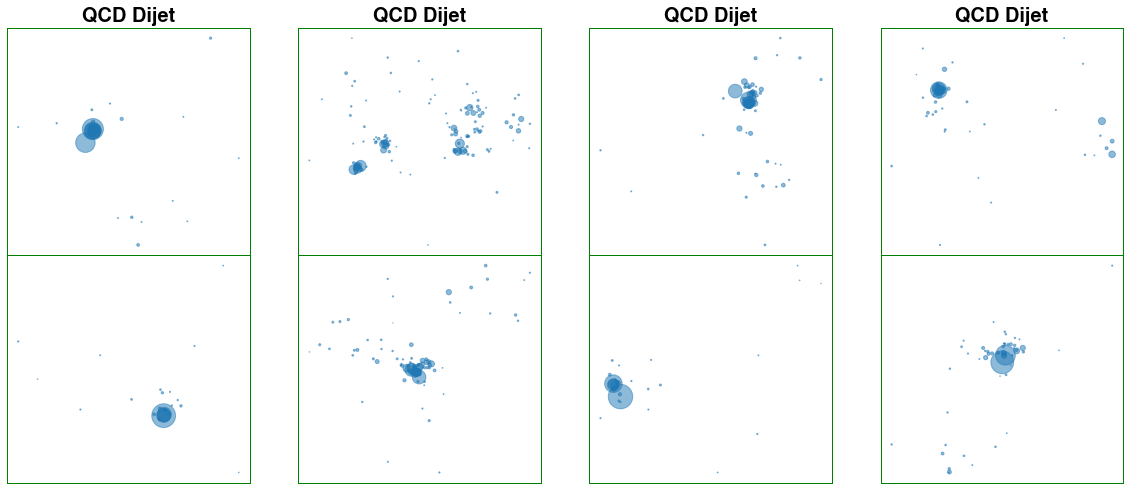

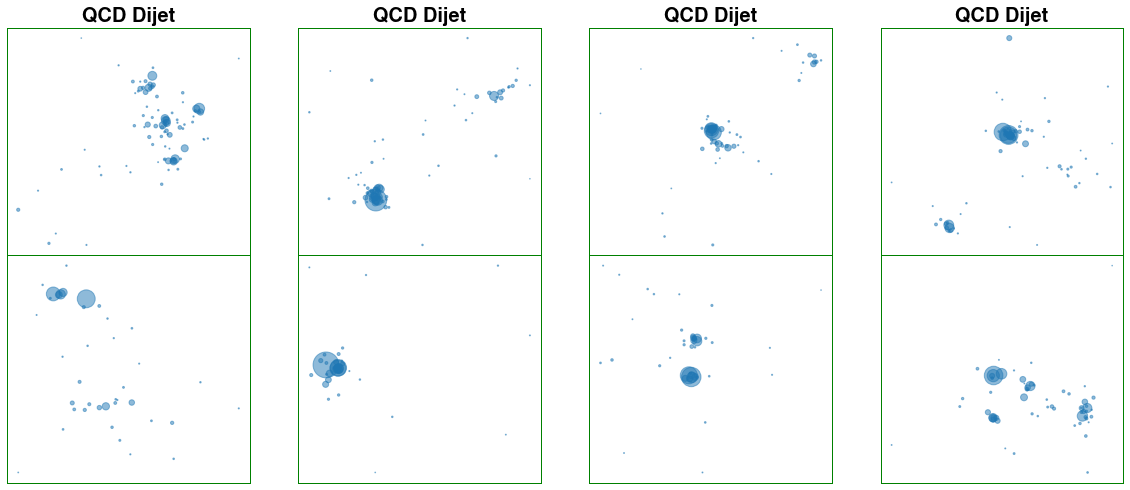

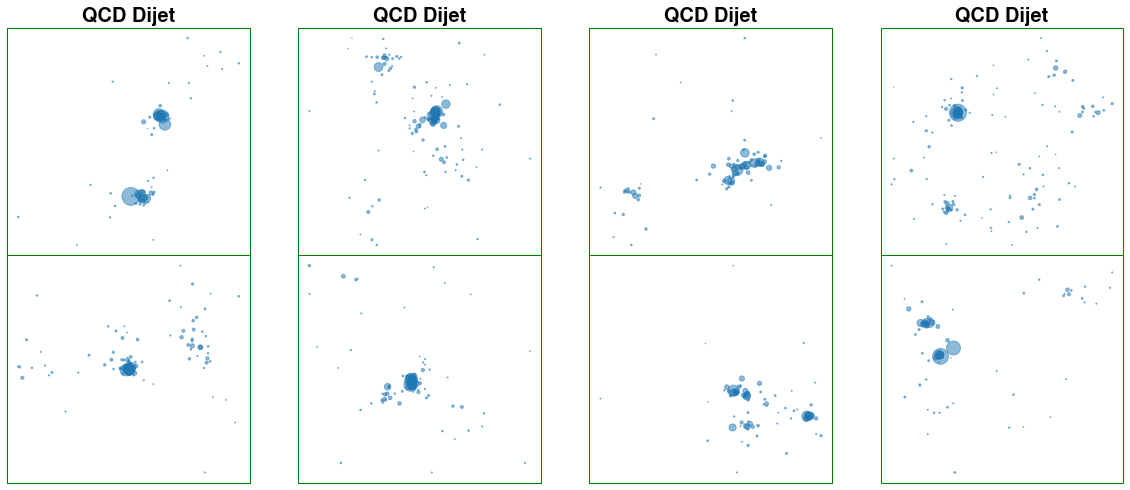

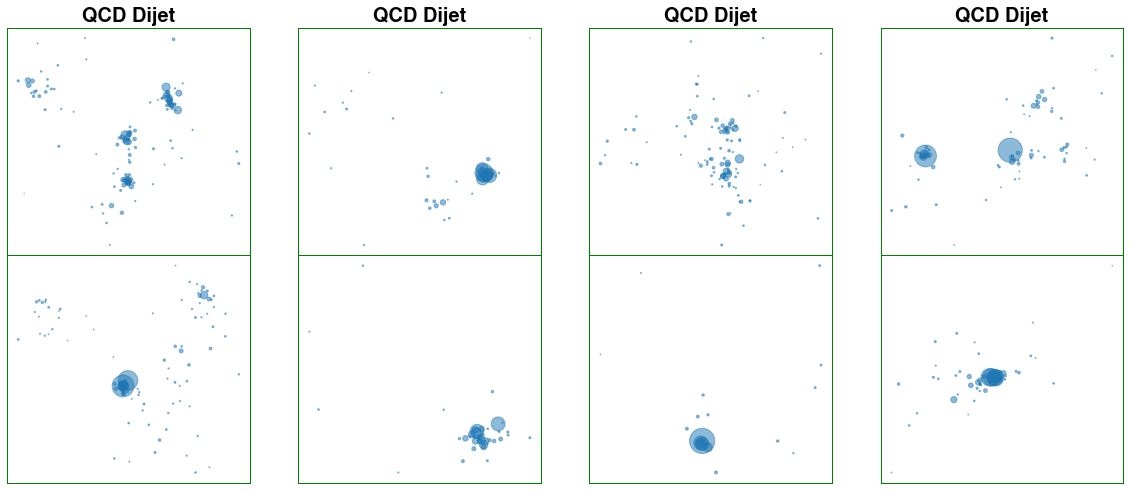

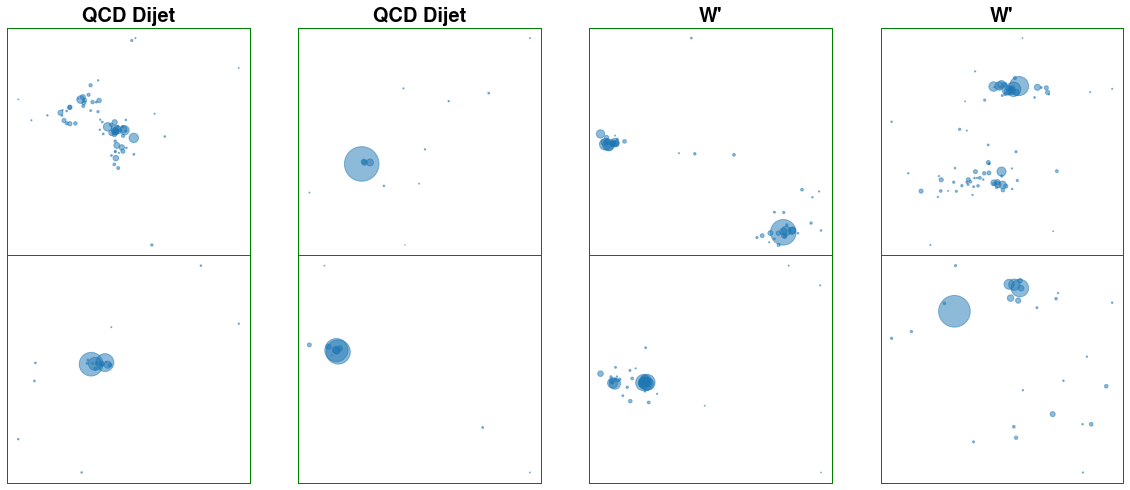

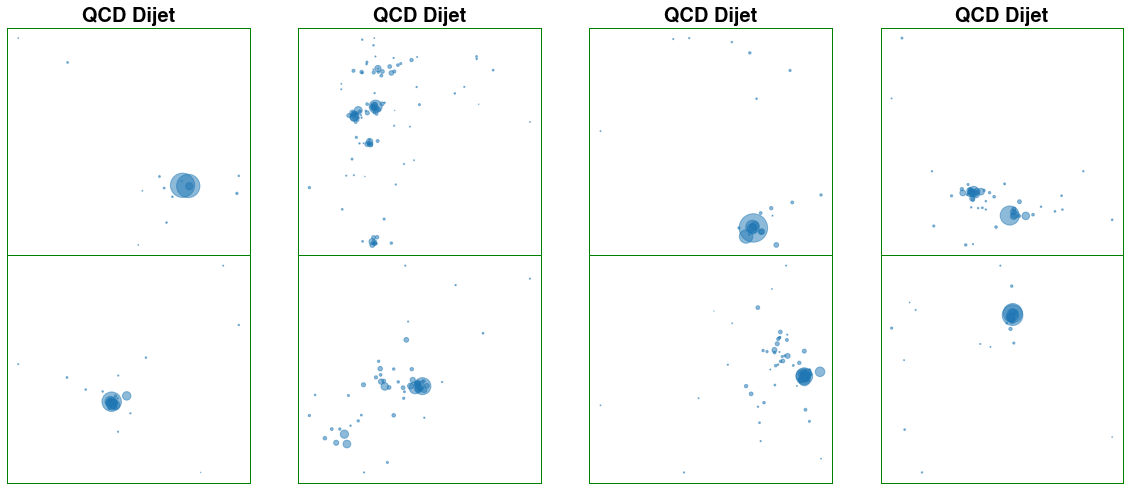

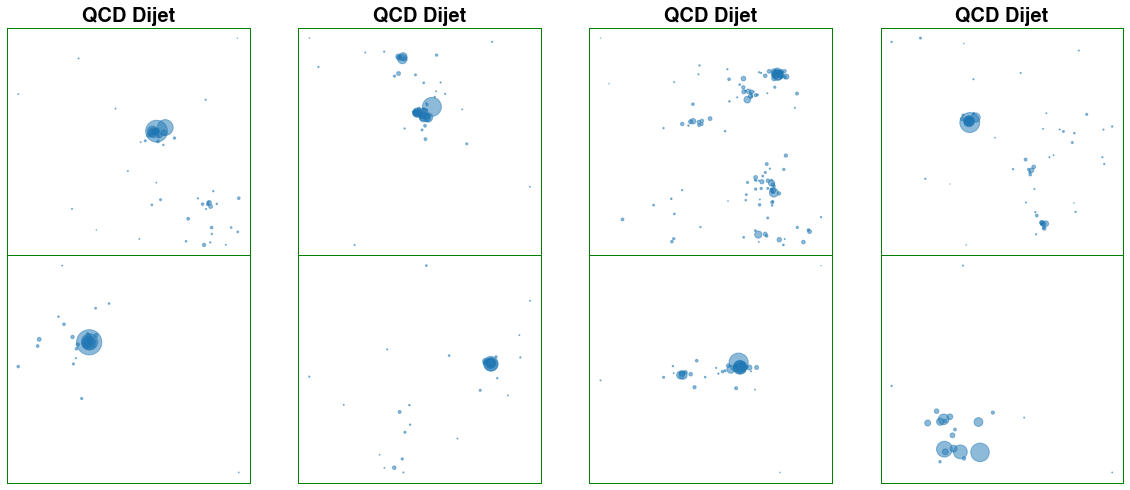

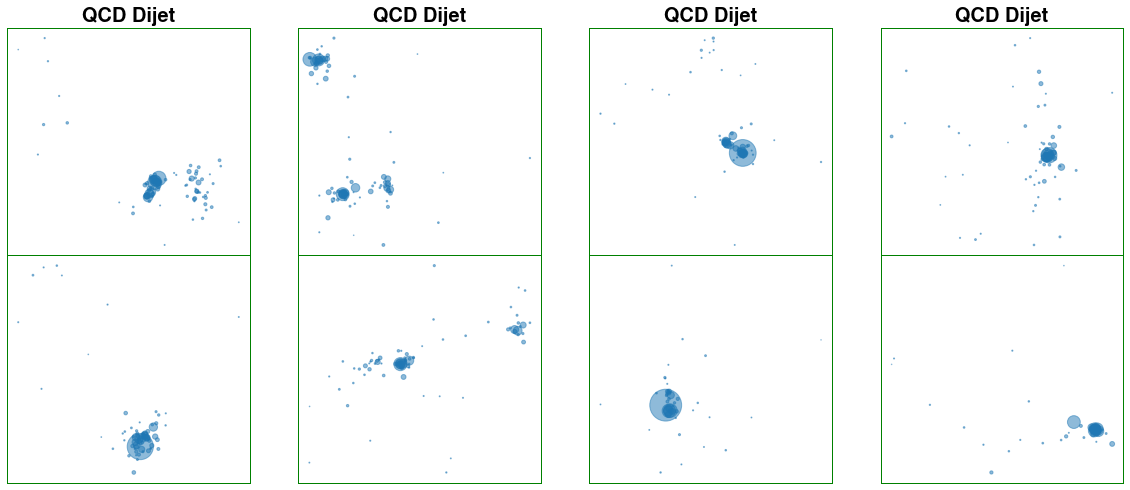

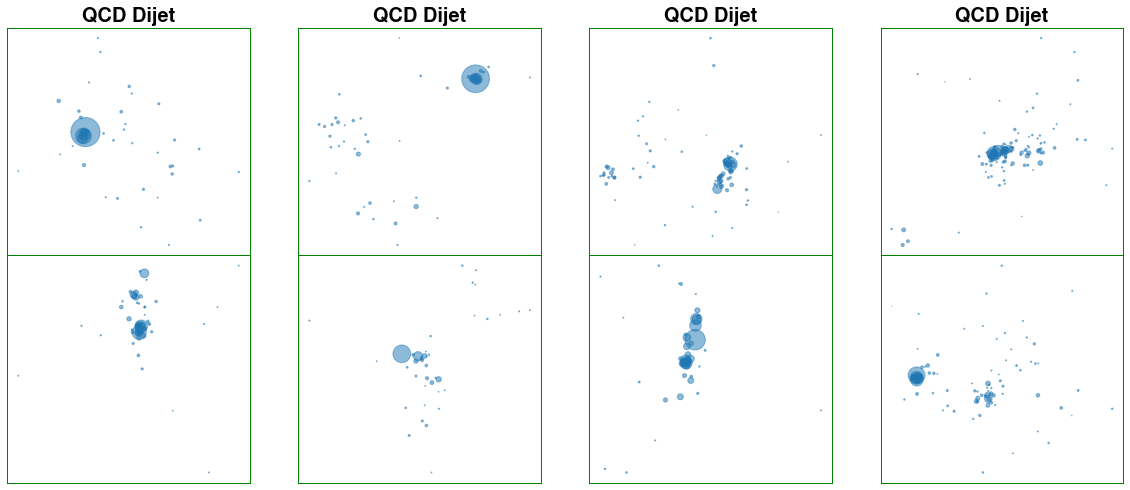

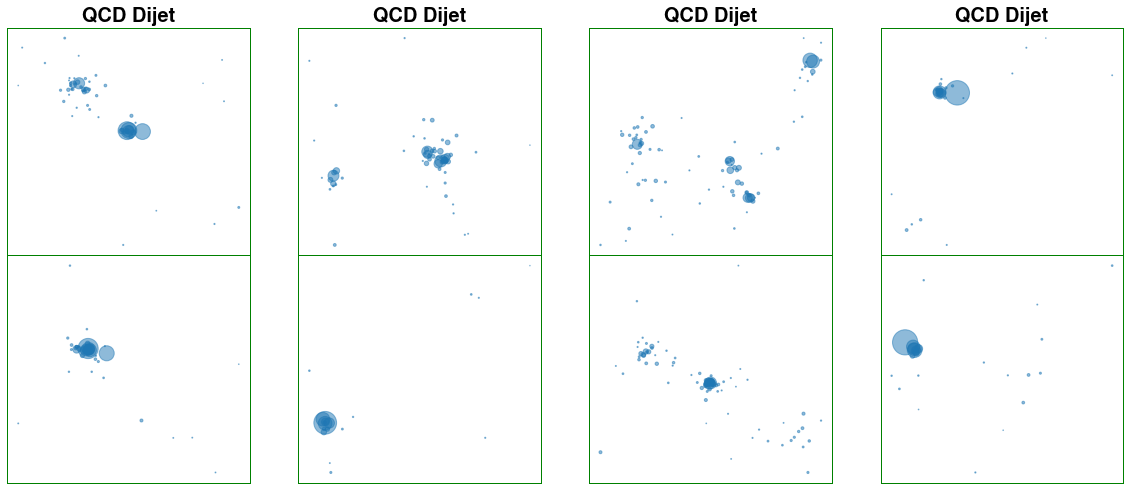

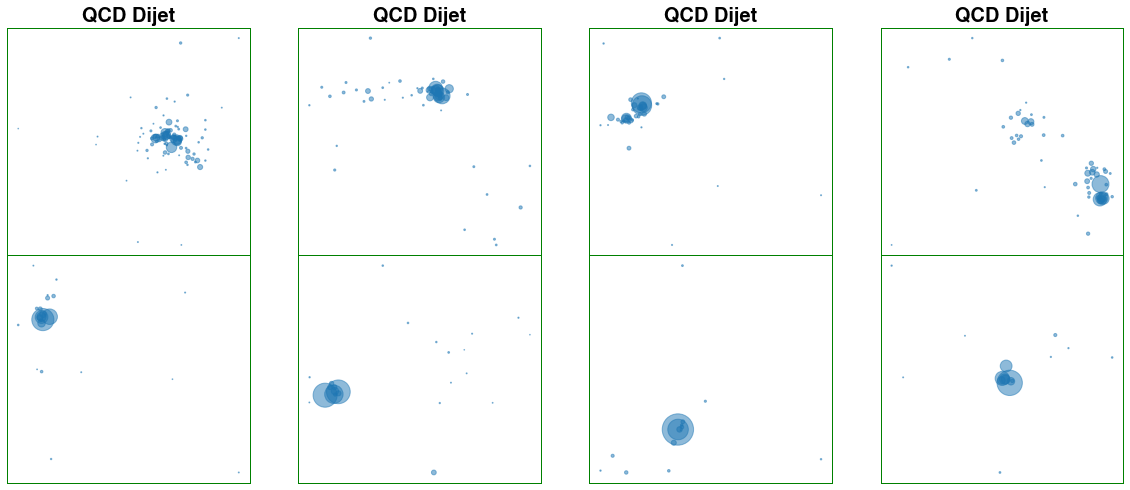

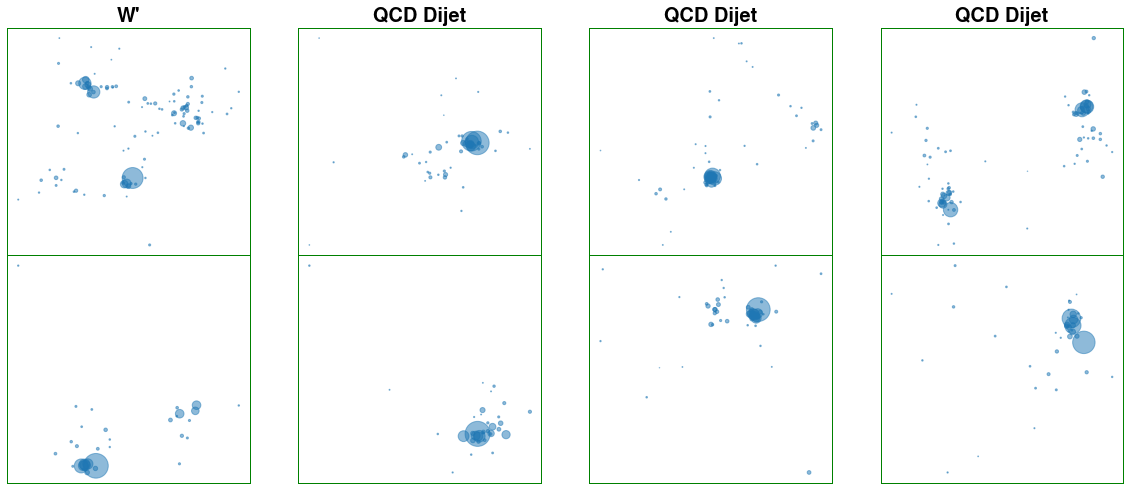

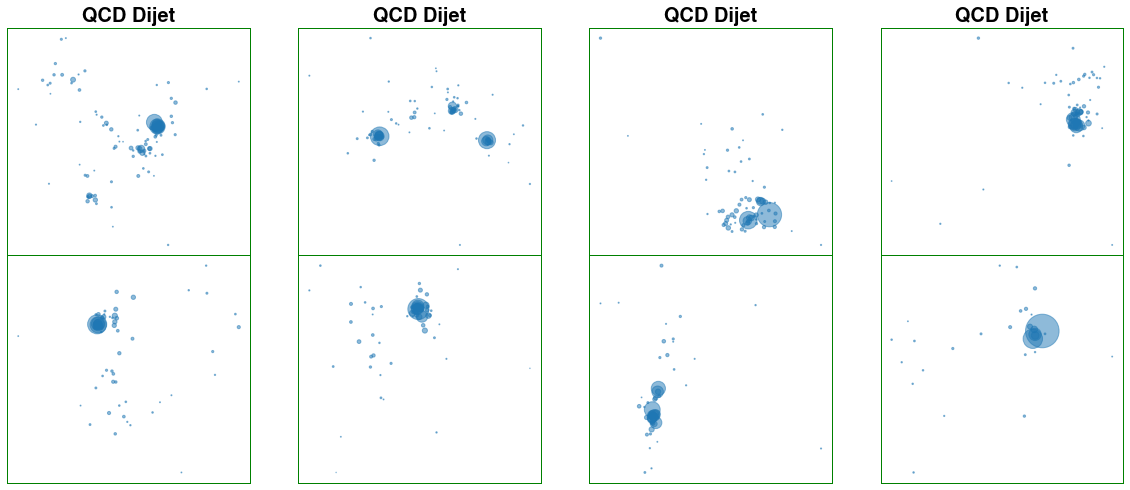

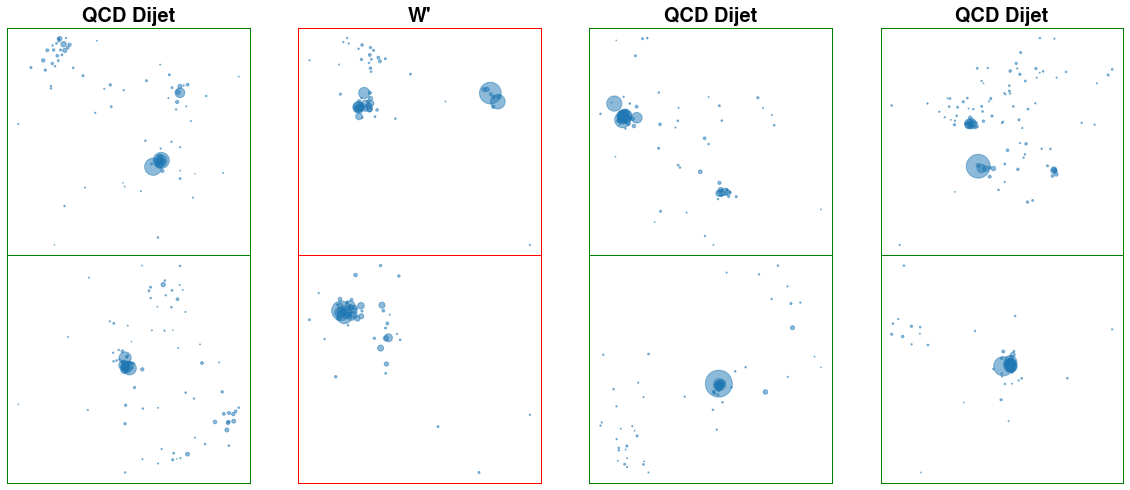

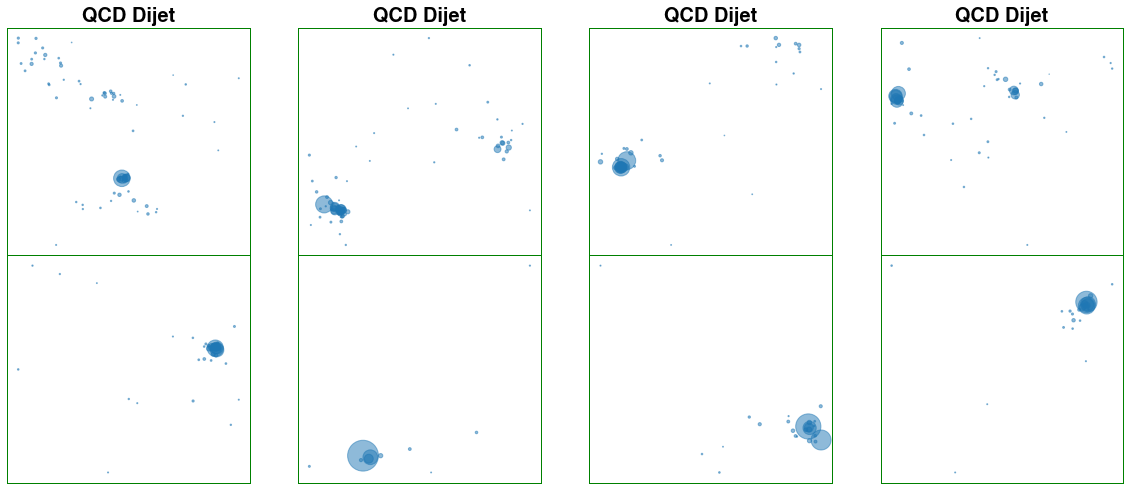

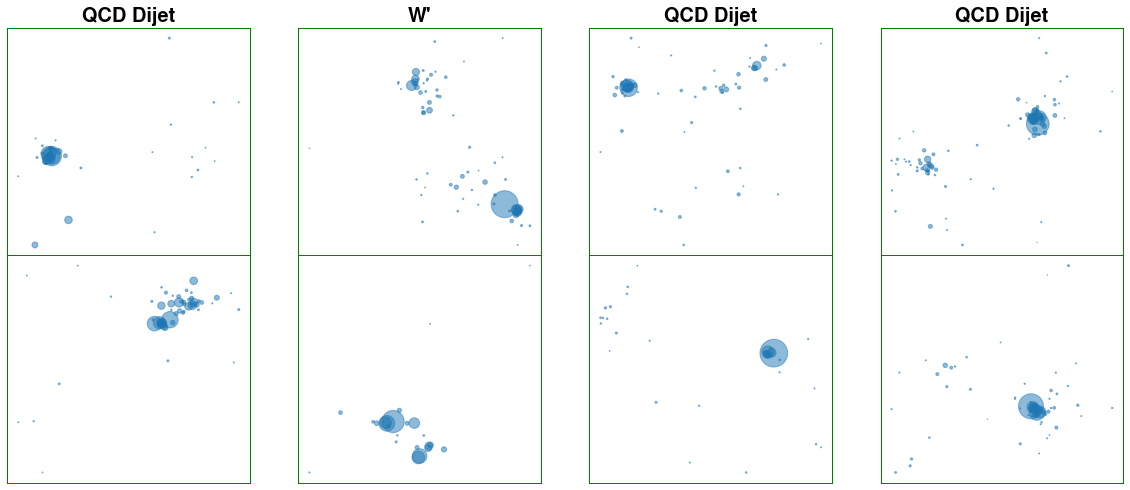

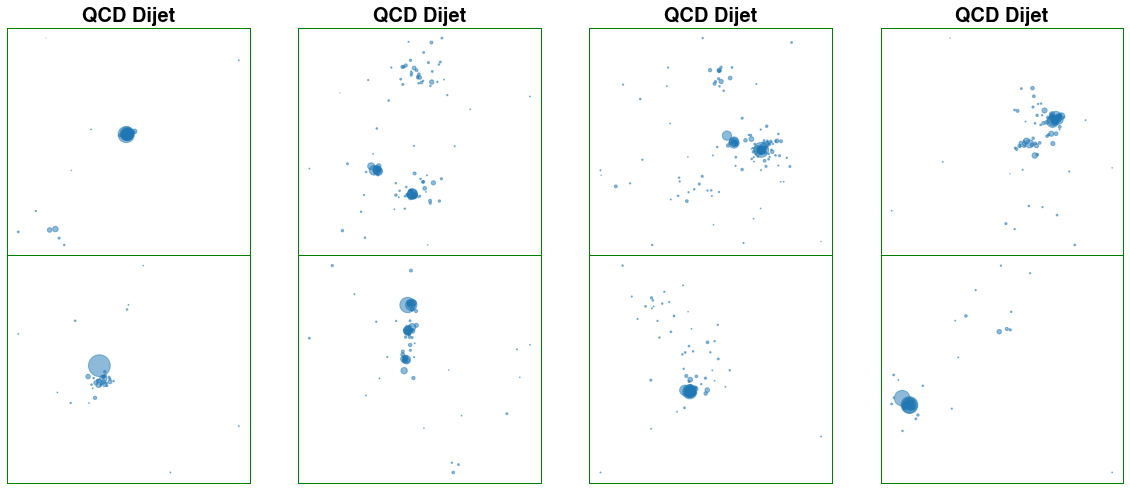

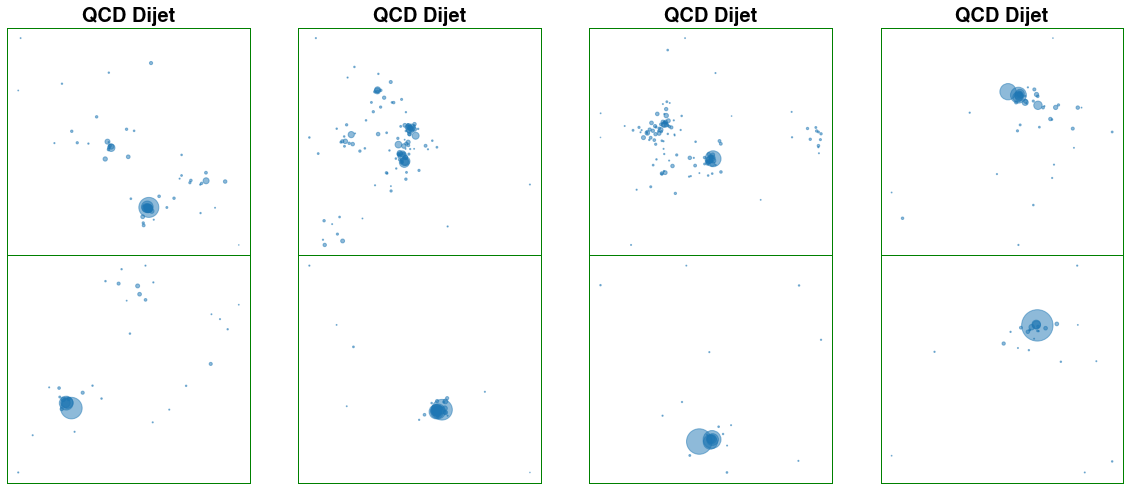

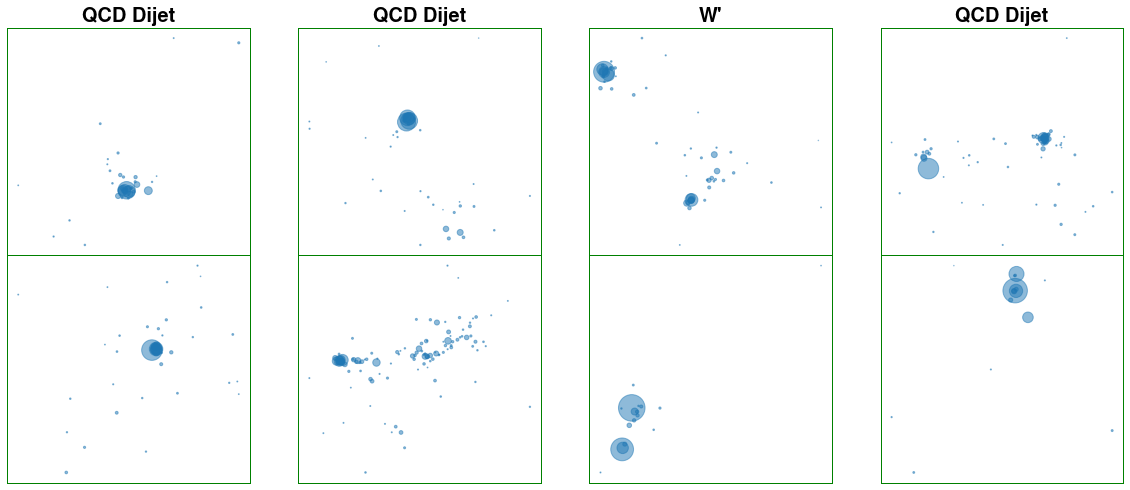

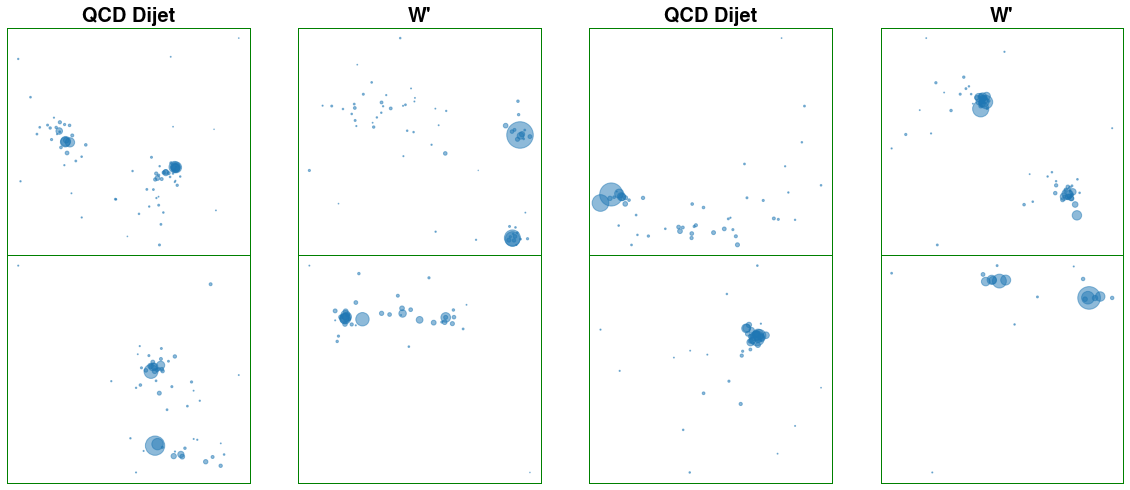

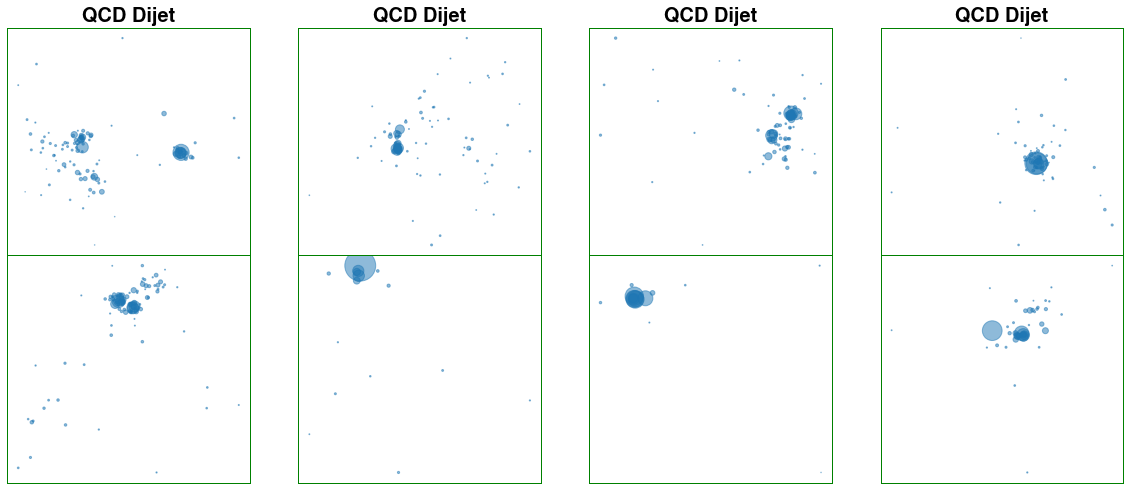

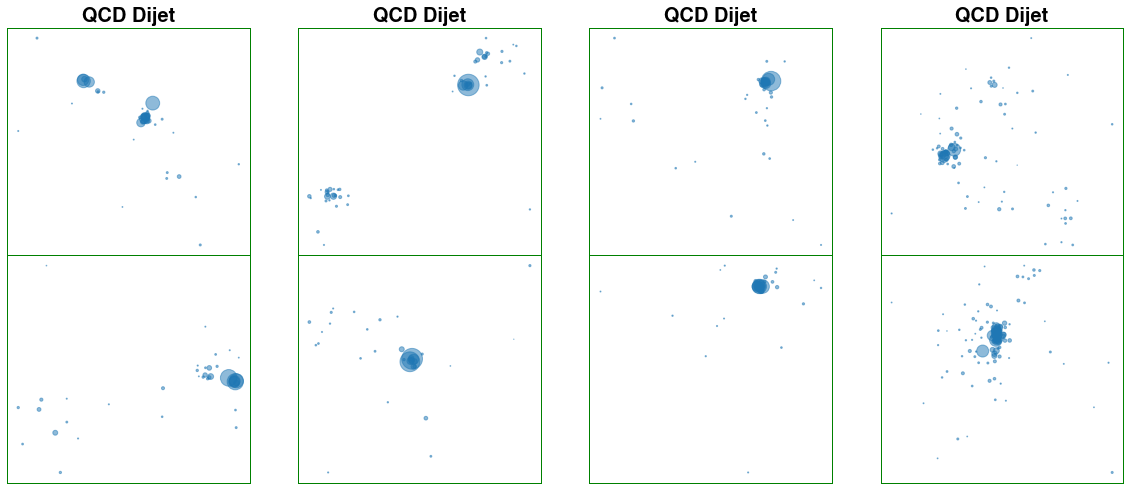

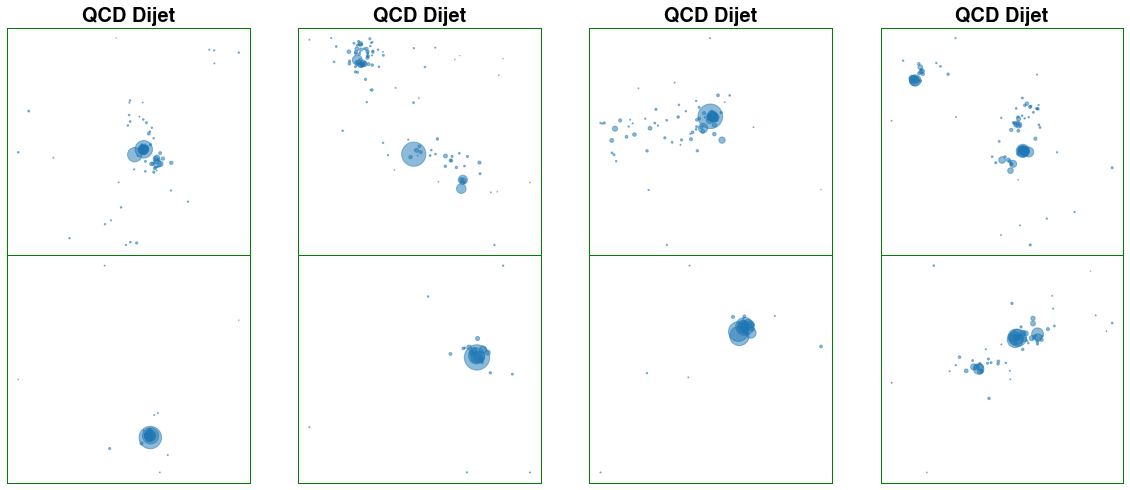

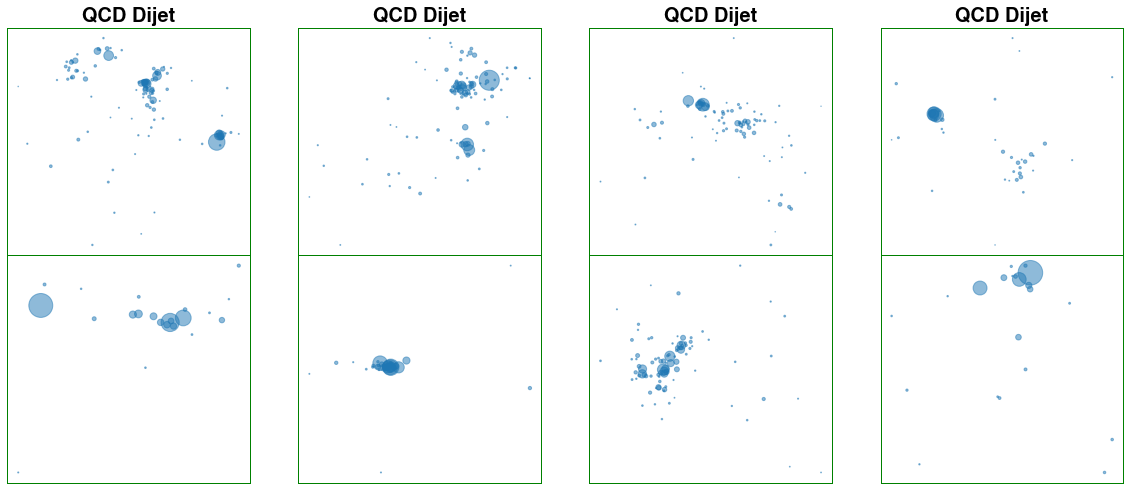

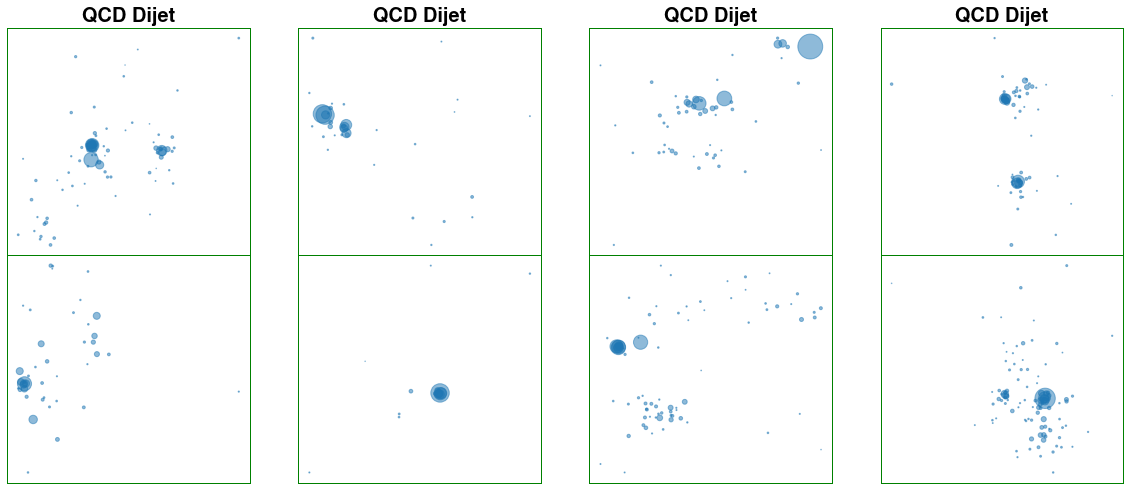

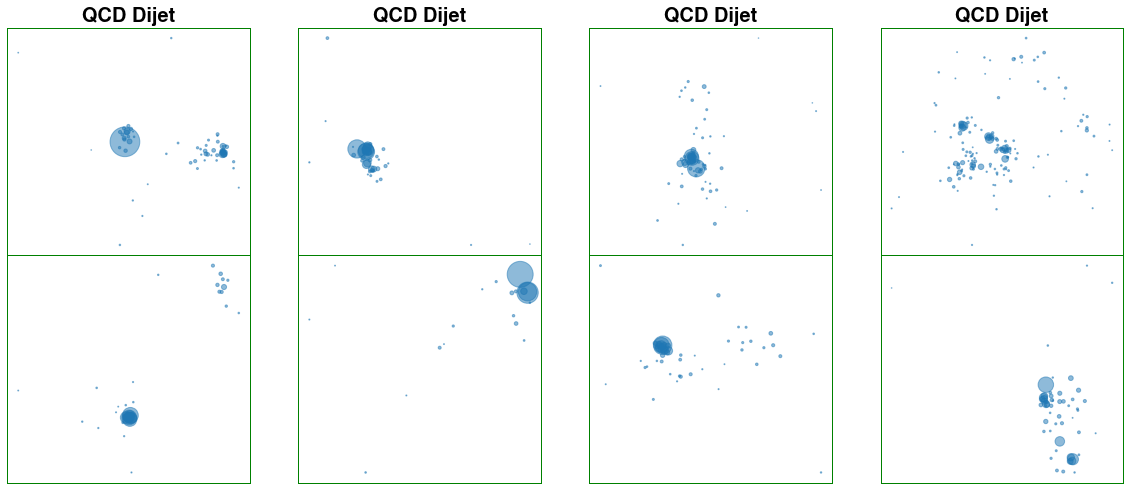

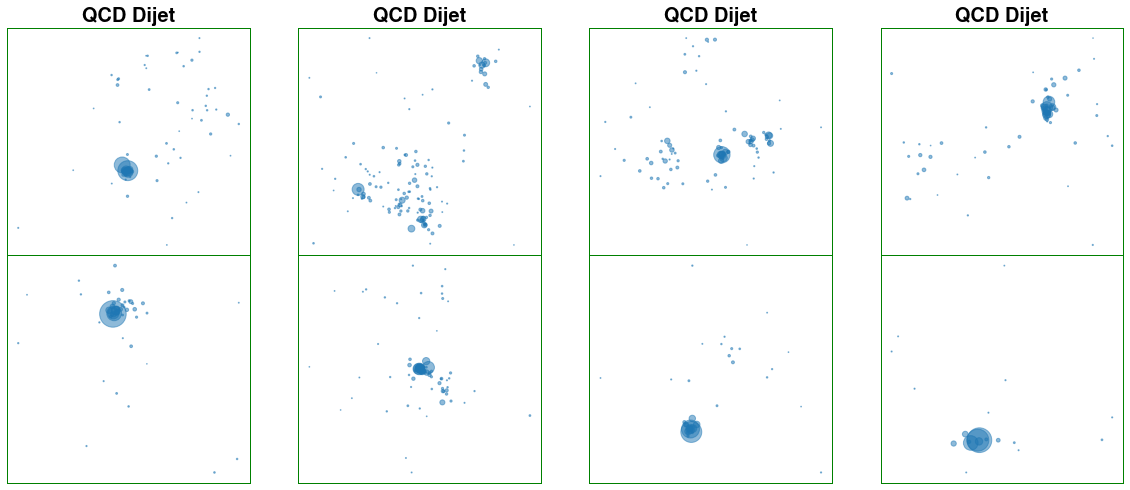

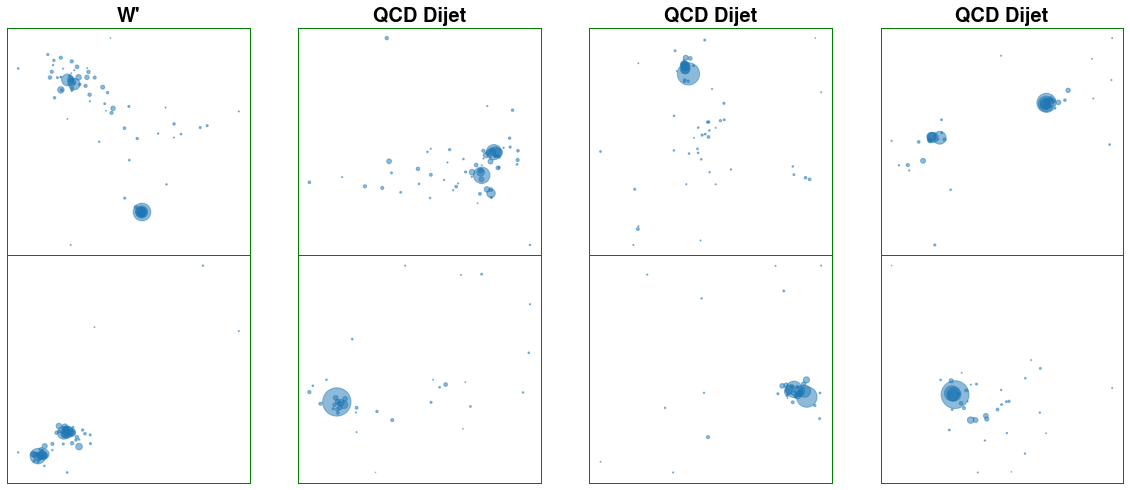

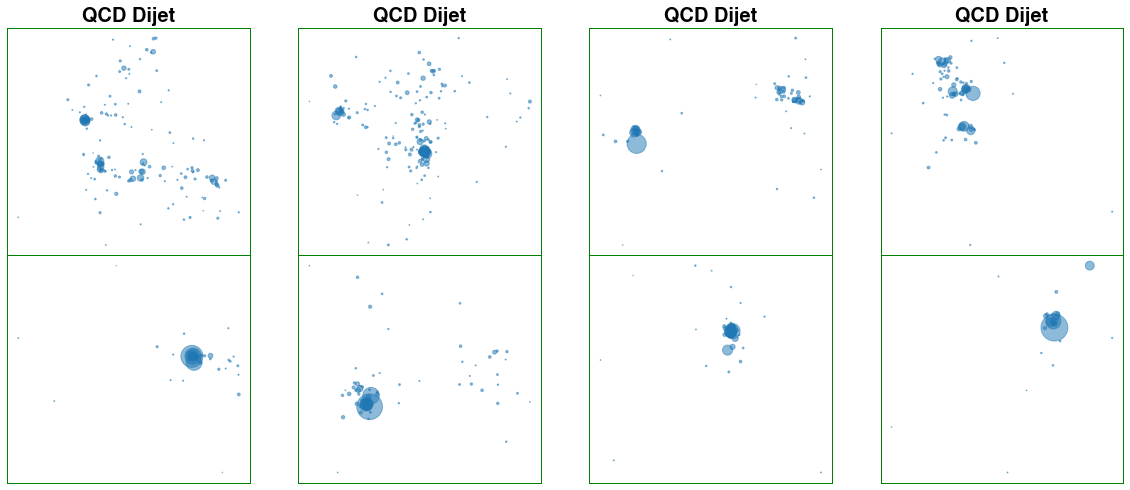

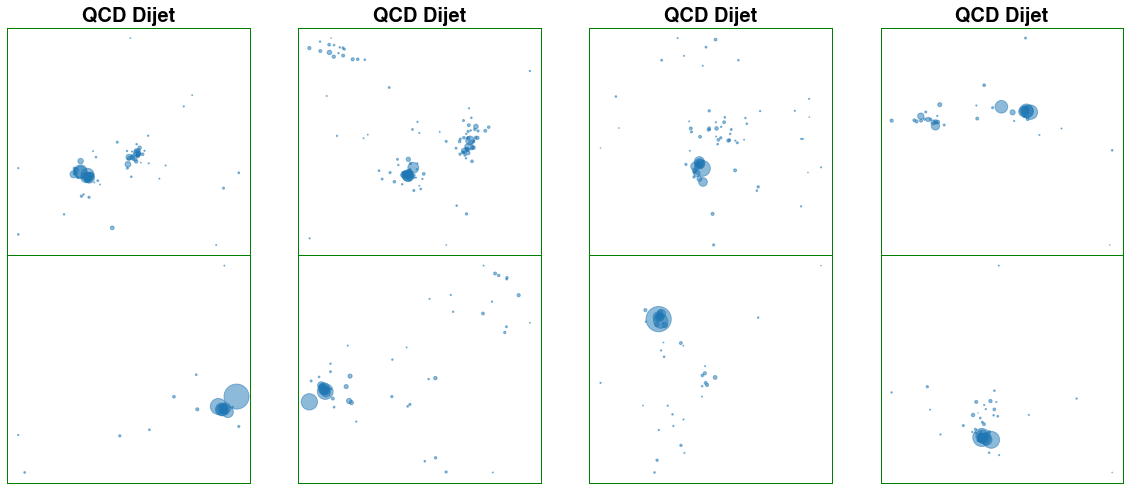

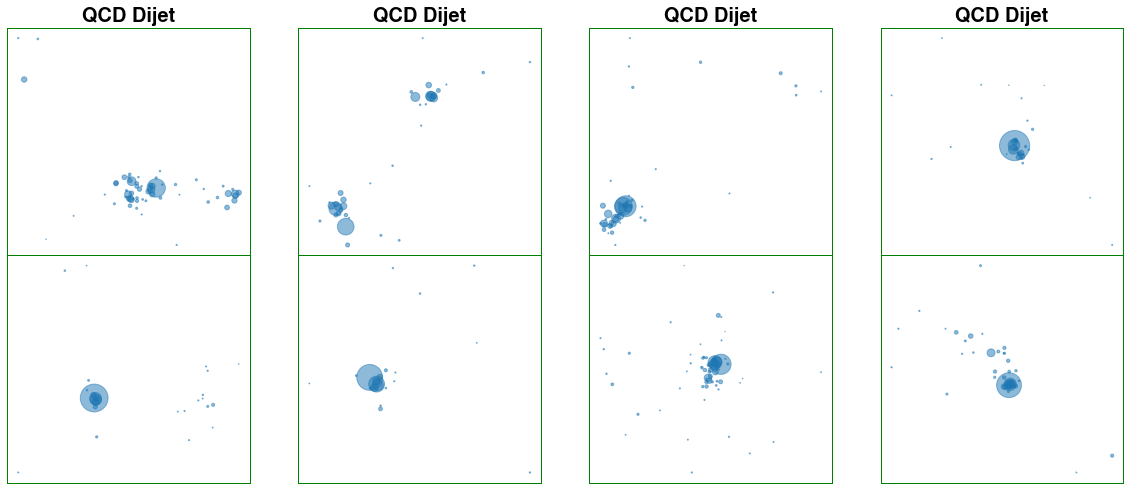

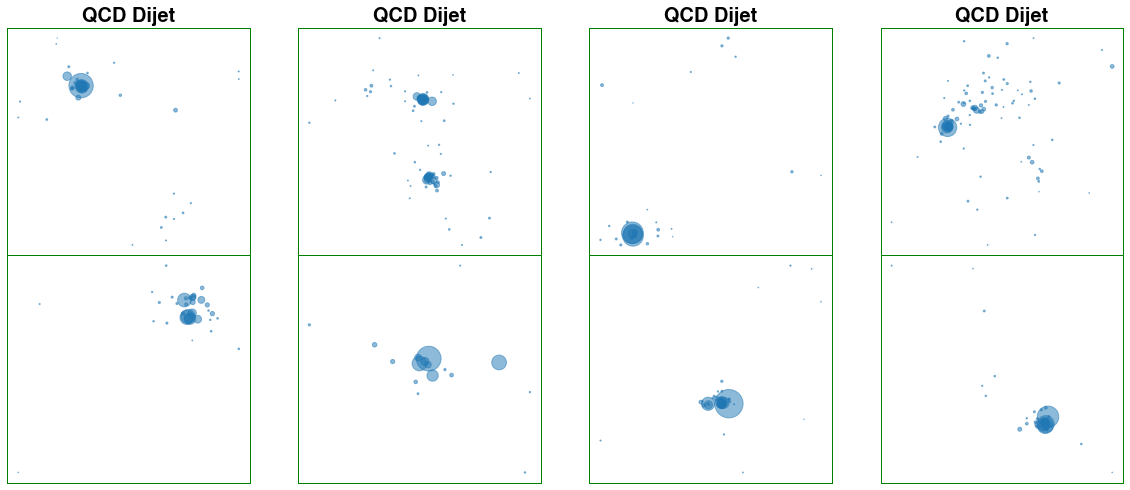

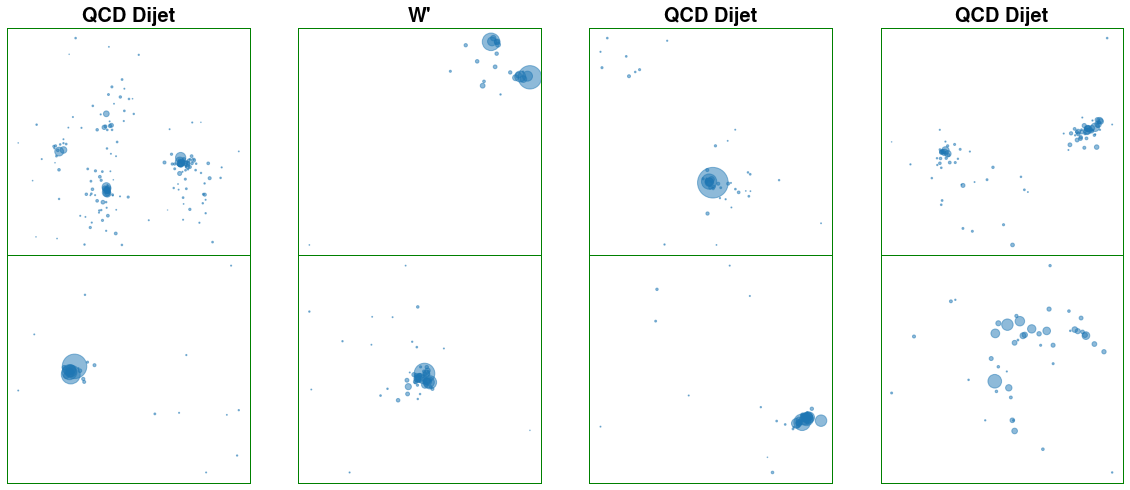

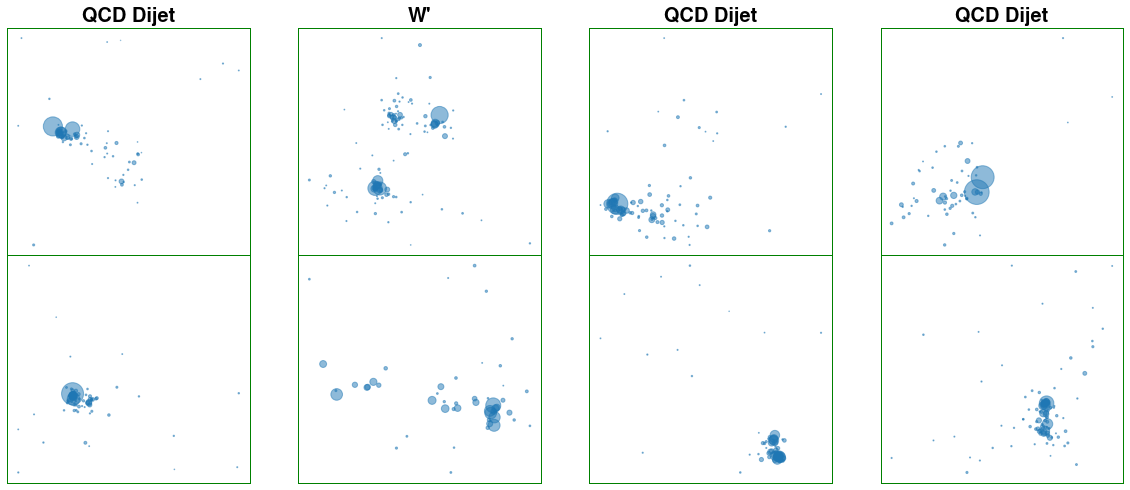

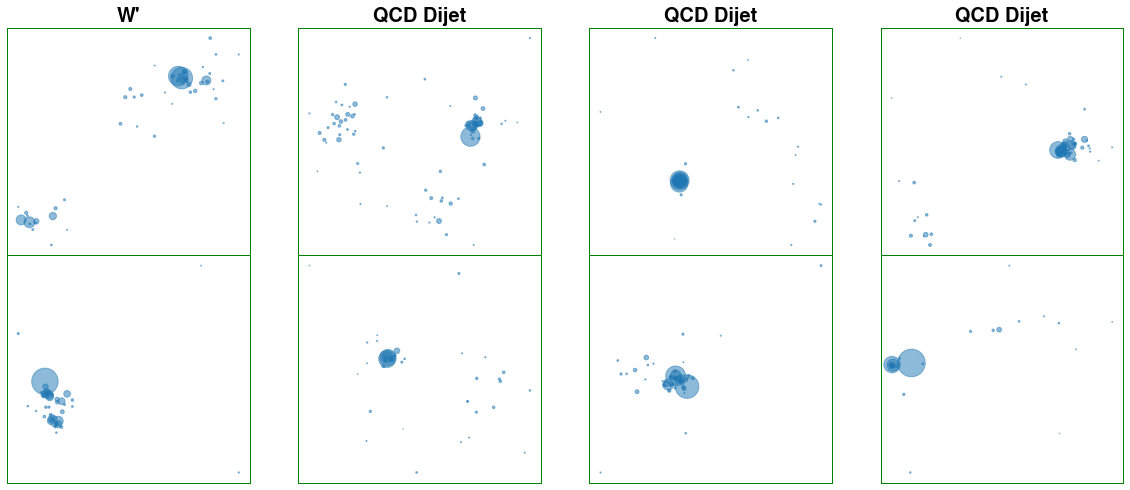

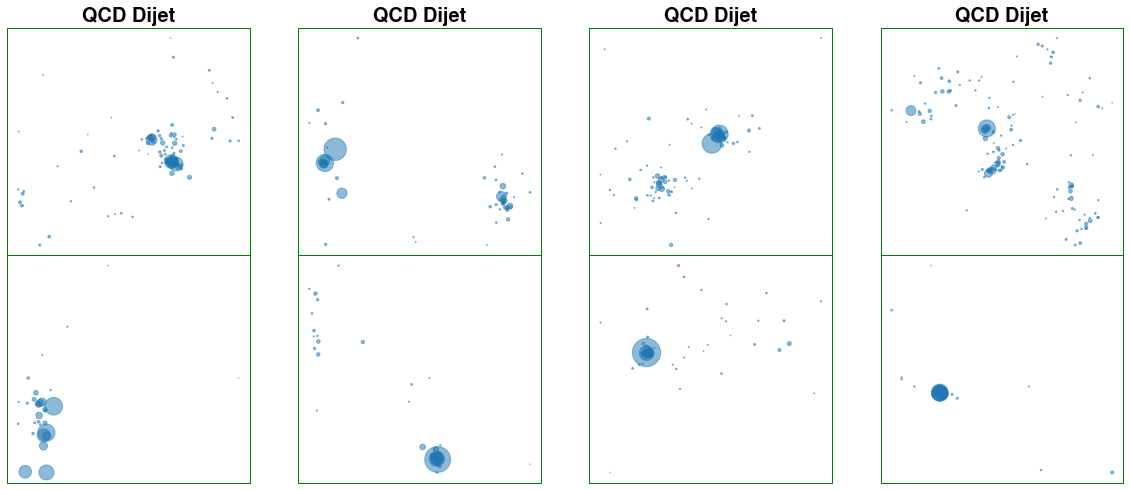

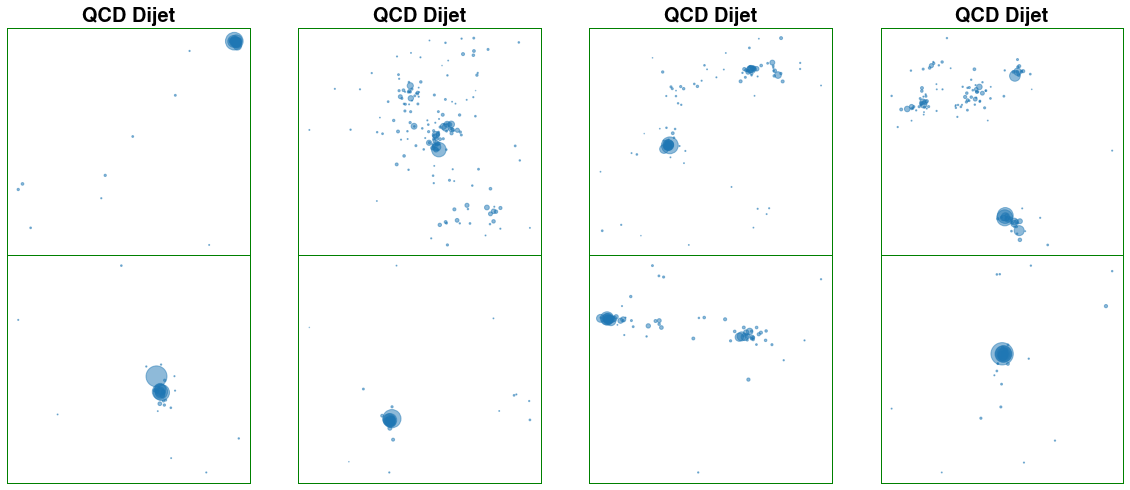

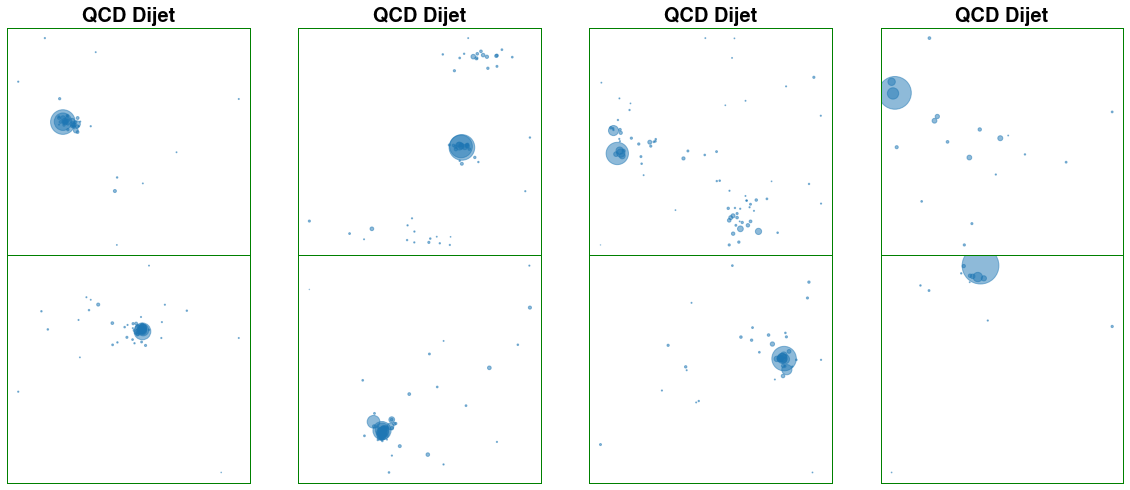

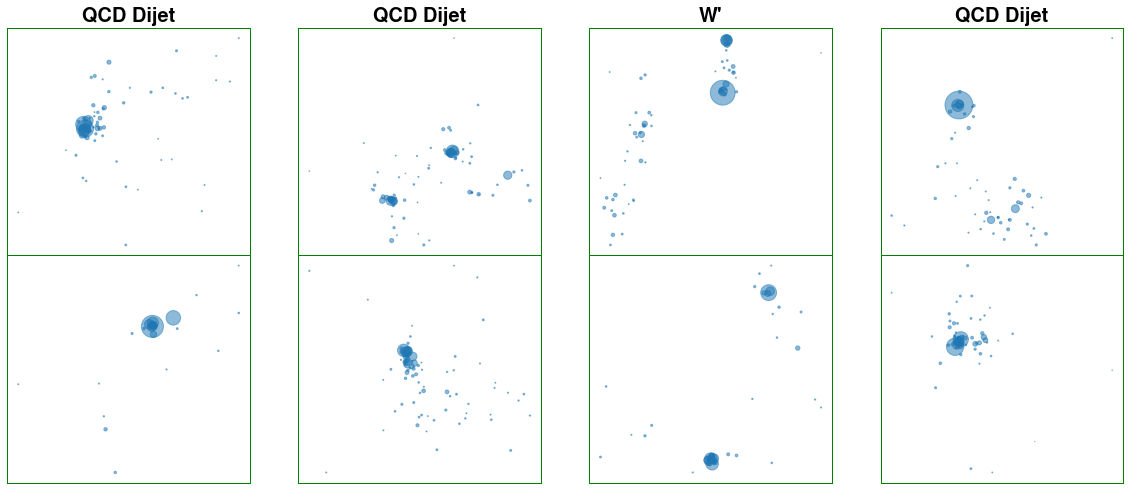

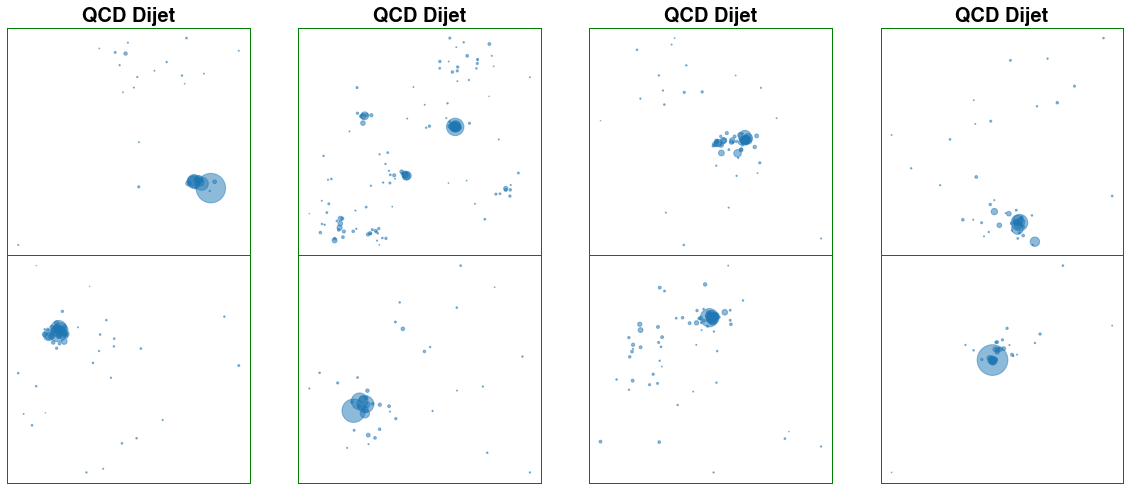

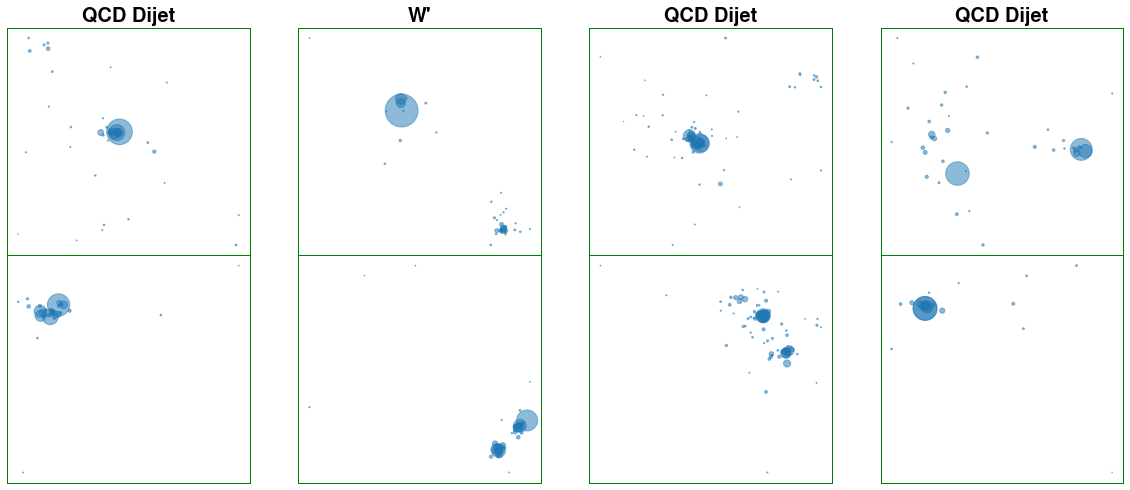

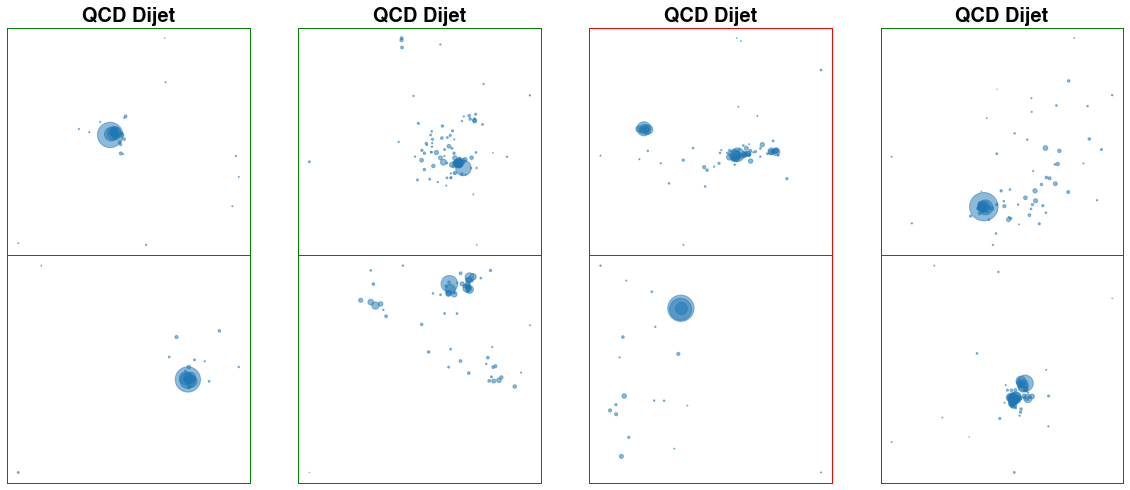

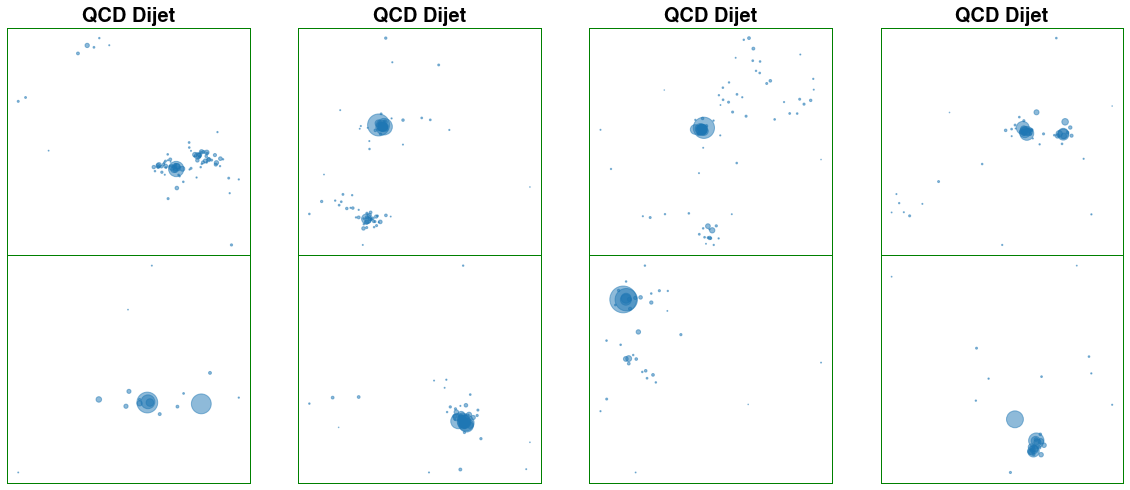

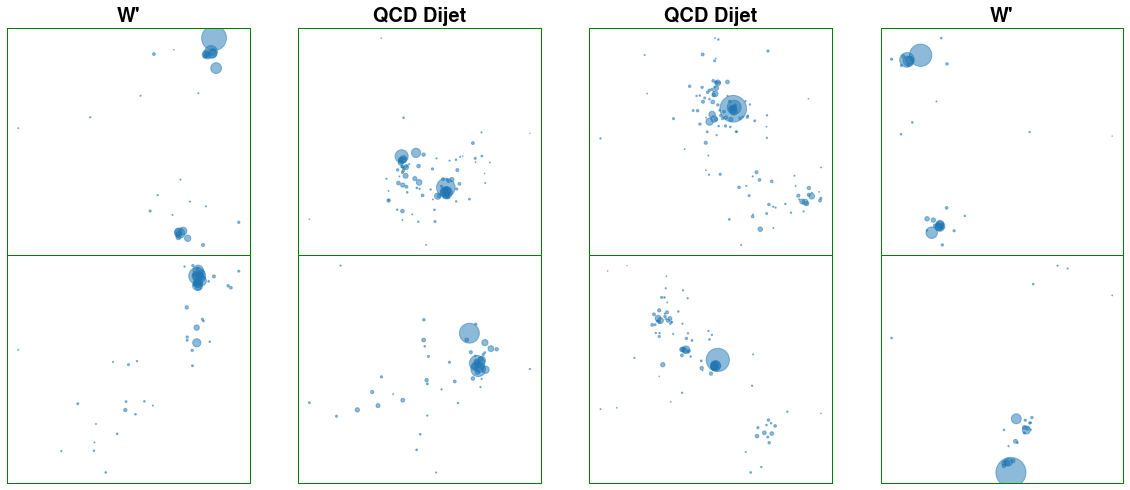

In [66]:
# show 200 events, I make the range such that there exists at least one wrongly labelled event
# those framed in green are correctly labelled, and those in red are incorrectly labelled
events_to_show = np.arange(1000)[:200]
display_event_image(x_features, x_masks, y_true, y_pred, events_to_show, ncol=1)